In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 934)
(3944610, 8)
validation
(464344, 934)
(464344, 8)
test
(574820, 934)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1647496 (6.28 MB)


Trainable params: 1647496 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:54 - loss: 2.3548 - STD: 0.1027 - MAE: 0.2194

  4/395 [..............................] - ETA: 6s - loss: 2.1633 - STD: 0.0603 - MAE: 0.2175  

  7/395 [..............................] - ETA: 6s - loss: 2.1274 - STD: 0.0536 - MAE: 0.2170

 10/395 [..............................] - ETA: 7s - loss: 2.1152 - STD: 0.0523 - MAE: 0.2168

 13/395 [..............................] - ETA: 7s - loss: 2.1039 - STD: 0.0505 - MAE: 0.2166

 16/395 [>.............................] - ETA: 7s - loss: 2.0942 - STD: 0.0471 - MAE: 0.2167

 19/395 [>.............................] - ETA: 7s - loss: 2.0884 - STD: 0.0442 - MAE: 0.2167

 22/395 [>.............................] - ETA: 7s - loss: 2.0844 - STD: 0.0425 - MAE: 0.2168

 25/395 [>.............................] - ETA: 7s - loss: 2.0807 - STD: 0.0413 - MAE: 0.2167

 28/395 [=>............................] - ETA: 7s - loss: 2.0773 - STD: 0.0402 - MAE: 0.2167

 31/395 [=>............................] - ETA: 7s - loss: 2.0745 - STD: 0.0392 - MAE: 0.2167

 34/395 [=>............................] - ETA: 7s - loss: 2.0719 - STD: 0.0387 - MAE: 0.2167

 37/395 [=>............................] - ETA: 7s - loss: 2.0690 - STD: 0.0386 - MAE: 0.2166

 40/395 [==>...........................] - ETA: 7s - loss: 2.0659 - STD: 0.0382 - MAE: 0.2166

 43/395 [==>...........................] - ETA: 7s - loss: 2.0625 - STD: 0.0378 - MAE: 0.2165

 46/395 [==>...........................] - ETA: 7s - loss: 2.0582 - STD: 0.0376 - MAE: 0.2163

 49/395 [==>...........................] - ETA: 7s - loss: 2.0530 - STD: 0.0379 - MAE: 0.2161

 52/395 [==>...........................] - ETA: 7s - loss: 2.0473 - STD: 0.0386 - MAE: 0.2159

 55/395 [===>..........................] - ETA: 6s - loss: 2.0406 - STD: 0.0398 - MAE: 0.2155

 58/395 [===>..........................] - ETA: 6s - loss: 2.0336 - STD: 0.0411 - MAE: 0.2152

 61/395 [===>..........................] - ETA: 6s - loss: 2.0261 - STD: 0.0425 - MAE: 0.2148

 64/395 [===>..........................] - ETA: 6s - loss: 2.0180 - STD: 0.0438 - MAE: 0.2144

 67/395 [====>.........................] - ETA: 6s - loss: 2.0095 - STD: 0.0452 - MAE: 0.2139

 70/395 [====>.........................] - ETA: 6s - loss: 2.0010 - STD: 0.0466 - MAE: 0.2135

 73/395 [====>.........................] - ETA: 6s - loss: 1.9924 - STD: 0.0481 - MAE: 0.2131

 76/395 [====>.........................] - ETA: 6s - loss: 1.9832 - STD: 0.0495 - MAE: 0.2126

 79/395 [=====>........................] - ETA: 6s - loss: 1.9733 - STD: 0.0510 - MAE: 0.2121

 82/395 [=====>........................] - ETA: 6s - loss: 1.9627 - STD: 0.0525 - MAE: 0.2115

 85/395 [=====>........................] - ETA: 6s - loss: 1.9515 - STD: 0.0541 - MAE: 0.2109

 88/395 [=====>........................] - ETA: 6s - loss: 1.9397 - STD: 0.0557 - MAE: 0.2103

 91/395 [=====>........................] - ETA: 6s - loss: 1.9272 - STD: 0.0575 - MAE: 0.2096

 94/395 [======>.......................] - ETA: 6s - loss: 1.9144 - STD: 0.0594 - MAE: 0.2089

 97/395 [======>.......................] - ETA: 8s - loss: 1.9043 - STD: 0.0613 - MAE: 0.2081

100/395 [======>.......................] - ETA: 7s - loss: 1.8920 - STD: 0.0633 - MAE: 0.2074

104/395 [======>.......................] - ETA: 7s - loss: 1.8759 - STD: 0.0659 - MAE: 0.2063

108/395 [=======>......................] - ETA: 7s - loss: 1.8604 - STD: 0.0684 - MAE: 0.2053

111/395 [=======>......................] - ETA: 7s - loss: 1.8491 - STD: 0.0702 - MAE: 0.2046

114/395 [=======>......................] - ETA: 7s - loss: 1.8381 - STD: 0.0720 - MAE: 0.2039

117/395 [=======>......................] - ETA: 7s - loss: 1.8275 - STD: 0.0737 - MAE: 0.2032

120/395 [========>.....................] - ETA: 7s - loss: 1.8170 - STD: 0.0753 - MAE: 0.2025

123/395 [========>.....................] - ETA: 6s - loss: 1.8069 - STD: 0.0769 - MAE: 0.2018

126/395 [========>.....................] - ETA: 6s - loss: 1.7970 - STD: 0.0785 - MAE: 0.2012

129/395 [========>.....................] - ETA: 6s - loss: 1.7873 - STD: 0.0801 - MAE: 0.2005

132/395 [=========>....................] - ETA: 6s - loss: 1.7778 - STD: 0.0815 - MAE: 0.1999

135/395 [=========>....................] - ETA: 6s - loss: 1.7686 - STD: 0.0830 - MAE: 0.1992

138/395 [=========>....................] - ETA: 6s - loss: 1.7597 - STD: 0.0844 - MAE: 0.1986

140/395 [=========>....................] - ETA: 6s - loss: 1.7539 - STD: 0.0853 - MAE: 0.1982

143/395 [=========>....................] - ETA: 6s - loss: 1.7454 - STD: 0.0867 - MAE: 0.1976

146/395 [==========>...................] - ETA: 6s - loss: 1.7368 - STD: 0.0880 - MAE: 0.1970

149/395 [==========>...................] - ETA: 6s - loss: 1.7288 - STD: 0.0893 - MAE: 0.1964

152/395 [==========>...................] - ETA: 5s - loss: 1.7207 - STD: 0.0906 - MAE: 0.1959

155/395 [==========>...................] - ETA: 5s - loss: 1.7128 - STD: 0.0918 - MAE: 0.1953

158/395 [===========>..................] - ETA: 5s - loss: 1.7050 - STD: 0.0931 - MAE: 0.1947

161/395 [===========>..................] - ETA: 5s - loss: 1.6977 - STD: 0.0943 - MAE: 0.1942

164/395 [===========>..................] - ETA: 5s - loss: 1.6904 - STD: 0.0954 - MAE: 0.1937

167/395 [===========>..................] - ETA: 5s - loss: 1.6831 - STD: 0.0966 - MAE: 0.1931

170/395 [===========>..................] - ETA: 5s - loss: 1.6765 - STD: 0.0977 - MAE: 0.1926

173/395 [============>.................] - ETA: 5s - loss: 1.6698 - STD: 0.0988 - MAE: 0.1921

176/395 [============>.................] - ETA: 5s - loss: 1.6632 - STD: 0.0999 - MAE: 0.1916

179/395 [============>.................] - ETA: 5s - loss: 1.6566 - STD: 0.1010 - MAE: 0.1911

182/395 [============>.................] - ETA: 5s - loss: 1.6501 - STD: 0.1020 - MAE: 0.1906

185/395 [=============>................] - ETA: 5s - loss: 1.6437 - STD: 0.1030 - MAE: 0.1901

188/395 [=============>................] - ETA: 4s - loss: 1.6375 - STD: 0.1040 - MAE: 0.1896

191/395 [=============>................] - ETA: 4s - loss: 1.6314 - STD: 0.1050 - MAE: 0.1892

194/395 [=============>................] - ETA: 4s - loss: 1.6253 - STD: 0.1059 - MAE: 0.1887

197/395 [=============>................] - ETA: 4s - loss: 1.6194 - STD: 0.1069 - MAE: 0.1882

200/395 [==============>...............] - ETA: 4s - loss: 1.6134 - STD: 0.1078 - MAE: 0.1877

203/395 [==============>...............] - ETA: 4s - loss: 1.6076 - STD: 0.1088 - MAE: 0.1873

206/395 [==============>...............] - ETA: 4s - loss: 1.6025 - STD: 0.1097 - MAE: 0.1869

209/395 [==============>...............] - ETA: 4s - loss: 1.5972 - STD: 0.1106 - MAE: 0.1864

212/395 [===============>..............] - ETA: 4s - loss: 1.5920 - STD: 0.1115 - MAE: 0.1860

215/395 [===============>..............] - ETA: 4s - loss: 1.5870 - STD: 0.1124 - MAE: 0.1856

218/395 [===============>..............] - ETA: 4s - loss: 1.5821 - STD: 0.1132 - MAE: 0.1852

221/395 [===============>..............] - ETA: 4s - loss: 1.5770 - STD: 0.1140 - MAE: 0.1848

224/395 [================>.............] - ETA: 3s - loss: 1.5721 - STD: 0.1149 - MAE: 0.1843

227/395 [================>.............] - ETA: 3s - loss: 1.5672 - STD: 0.1157 - MAE: 0.1839

230/395 [================>.............] - ETA: 3s - loss: 1.5625 - STD: 0.1165 - MAE: 0.1835

233/395 [================>.............] - ETA: 3s - loss: 1.5579 - STD: 0.1173 - MAE: 0.1832

236/395 [================>.............] - ETA: 3s - loss: 1.5534 - STD: 0.1180 - MAE: 0.1828

239/395 [=================>............] - ETA: 3s - loss: 1.5489 - STD: 0.1187 - MAE: 0.1824

242/395 [=================>............] - ETA: 3s - loss: 1.5444 - STD: 0.1195 - MAE: 0.1820

245/395 [=================>............] - ETA: 3s - loss: 1.5401 - STD: 0.1202 - MAE: 0.1817

248/395 [=================>............] - ETA: 3s - loss: 1.5358 - STD: 0.1209 - MAE: 0.1813

251/395 [==================>...........] - ETA: 3s - loss: 1.5316 - STD: 0.1216 - MAE: 0.1810

254/395 [==================>...........] - ETA: 3s - loss: 1.5276 - STD: 0.1223 - MAE: 0.1806

257/395 [==================>...........] - ETA: 3s - loss: 1.5236 - STD: 0.1230 - MAE: 0.1803

260/395 [==================>...........] - ETA: 3s - loss: 1.5199 - STD: 0.1236 - MAE: 0.1800

263/395 [==================>...........] - ETA: 3s - loss: 1.5163 - STD: 0.1243 - MAE: 0.1797

266/395 [===================>..........] - ETA: 2s - loss: 1.5125 - STD: 0.1249 - MAE: 0.1793

269/395 [===================>..........] - ETA: 2s - loss: 1.5088 - STD: 0.1256 - MAE: 0.1790

272/395 [===================>..........] - ETA: 2s - loss: 1.5052 - STD: 0.1262 - MAE: 0.1787

275/395 [===================>..........] - ETA: 2s - loss: 1.5016 - STD: 0.1268 - MAE: 0.1784

278/395 [====================>.........] - ETA: 2s - loss: 1.4981 - STD: 0.1274 - MAE: 0.1781

281/395 [====================>.........] - ETA: 2s - loss: 1.4946 - STD: 0.1280 - MAE: 0.1778

284/395 [====================>.........] - ETA: 2s - loss: 1.4911 - STD: 0.1286 - MAE: 0.1775

287/395 [====================>.........] - ETA: 2s - loss: 1.4876 - STD: 0.1292 - MAE: 0.1772

290/395 [=====================>........] - ETA: 2s - loss: 1.4843 - STD: 0.1297 - MAE: 0.1769

293/395 [=====================>........] - ETA: 2s - loss: 1.4809 - STD: 0.1303 - MAE: 0.1766

296/395 [=====================>........] - ETA: 2s - loss: 1.4776 - STD: 0.1308 - MAE: 0.1763

298/395 [=====================>........] - ETA: 2s - loss: 1.4755 - STD: 0.1312 - MAE: 0.1761

301/395 [=====================>........] - ETA: 2s - loss: 1.4724 - STD: 0.1317 - MAE: 0.1759

304/395 [======================>.......] - ETA: 2s - loss: 1.4696 - STD: 0.1322 - MAE: 0.1756

307/395 [======================>.......] - ETA: 1s - loss: 1.4666 - STD: 0.1327 - MAE: 0.1754

310/395 [======================>.......] - ETA: 1s - loss: 1.4638 - STD: 0.1332 - MAE: 0.1751

313/395 [======================>.......] - ETA: 1s - loss: 1.4611 - STD: 0.1337 - MAE: 0.1749

316/395 [=======================>......] - ETA: 1s - loss: 1.4582 - STD: 0.1342 - MAE: 0.1746

319/395 [=======================>......] - ETA: 1s - loss: 1.4554 - STD: 0.1347 - MAE: 0.1744

322/395 [=======================>......] - ETA: 1s - loss: 1.4526 - STD: 0.1352 - MAE: 0.1741

325/395 [=======================>......] - ETA: 1s - loss: 1.4498 - STD: 0.1356 - MAE: 0.1739

328/395 [=======================>......] - ETA: 1s - loss: 1.4469 - STD: 0.1361 - MAE: 0.1736

331/395 [========================>.....] - ETA: 1s - loss: 1.4442 - STD: 0.1366 - MAE: 0.1734

334/395 [========================>.....] - ETA: 1s - loss: 1.4414 - STD: 0.1370 - MAE: 0.1732

337/395 [========================>.....] - ETA: 1s - loss: 1.4387 - STD: 0.1374 - MAE: 0.1729

340/395 [========================>.....] - ETA: 1s - loss: 1.4361 - STD: 0.1379 - MAE: 0.1727

343/395 [=========================>....] - ETA: 1s - loss: 1.4335 - STD: 0.1383 - MAE: 0.1725

346/395 [=========================>....] - ETA: 1s - loss: 1.4310 - STD: 0.1388 - MAE: 0.1722

349/395 [=========================>....] - ETA: 1s - loss: 1.4284 - STD: 0.1392 - MAE: 0.1720

352/395 [=========================>....] - ETA: 0s - loss: 1.4259 - STD: 0.1396 - MAE: 0.1718

355/395 [=========================>....] - ETA: 0s - loss: 1.4235 - STD: 0.1400 - MAE: 0.1716

358/395 [==========================>...] - ETA: 0s - loss: 1.4211 - STD: 0.1404 - MAE: 0.1714

361/395 [==========================>...] - ETA: 0s - loss: 1.4187 - STD: 0.1408 - MAE: 0.1712

364/395 [==========================>...] - ETA: 0s - loss: 1.4162 - STD: 0.1412 - MAE: 0.1709

367/395 [==========================>...] - ETA: 0s - loss: 1.4139 - STD: 0.1416 - MAE: 0.1707

370/395 [===========================>..] - ETA: 0s - loss: 1.4116 - STD: 0.1420 - MAE: 0.1705

373/395 [===========================>..] - ETA: 0s - loss: 1.4093 - STD: 0.1424 - MAE: 0.1703

376/395 [===========================>..] - ETA: 0s - loss: 1.4070 - STD: 0.1428 - MAE: 0.1701

379/395 [===========================>..] - ETA: 0s - loss: 1.4047 - STD: 0.1432 - MAE: 0.1699

382/395 [============================>.] - ETA: 0s - loss: 1.4025 - STD: 0.1435 - MAE: 0.1697

385/395 [============================>.] - ETA: 0s - loss: 1.4003 - STD: 0.1439 - MAE: 0.1695

388/395 [============================>.] - ETA: 0s - loss: 1.3982 - STD: 0.1443 - MAE: 0.1693

391/395 [============================>.] - ETA: 0s - loss: 1.3962 - STD: 0.1446 - MAE: 0.1691

394/395 [============================>.] - ETA: 0s - loss: 1.3941 - STD: 0.1450 - MAE: 0.1689

395/395 [==============================] - 12s 26ms/step - loss: 1.3935 - STD: 0.1451 - MAE: 0.1689 - val_loss: 1.1873 - val_STD: 0.1920 - val_MAE: 0.1449


Epoch 2/10000


  1/395 [..............................] - ETA: 19s - loss: 1.1395 - STD: 0.1899 - MAE: 0.1461

  4/395 [..............................] - ETA: 8s - loss: 1.1239 - STD: 0.1902 - MAE: 0.1448 

  7/395 [..............................] - ETA: 8s - loss: 1.1326 - STD: 0.1907 - MAE: 0.1451

 10/395 [..............................] - ETA: 7s - loss: 1.1304 - STD: 0.1911 - MAE: 0.1449

 13/395 [..............................] - ETA: 7s - loss: 1.1302 - STD: 0.1911 - MAE: 0.1448

 16/395 [>.............................] - ETA: 7s - loss: 1.1315 - STD: 0.1912 - MAE: 0.1449

 19/395 [>.............................] - ETA: 7s - loss: 1.1295 - STD: 0.1913 - MAE: 0.1447

 22/395 [>.............................] - ETA: 7s - loss: 1.1263 - STD: 0.1913 - MAE: 0.1446

 25/395 [>.............................] - ETA: 7s - loss: 1.1236 - STD: 0.1913 - MAE: 0.1444

 28/395 [=>............................] - ETA: 7s - loss: 1.1224 - STD: 0.1916 - MAE: 0.1443

 31/395 [=>............................] - ETA: 7s - loss: 1.1204 - STD: 0.1917 - MAE: 0.1441

 34/395 [=>............................] - ETA: 7s - loss: 1.1193 - STD: 0.1918 - MAE: 0.1440

 37/395 [=>............................] - ETA: 7s - loss: 1.1188 - STD: 0.1919 - MAE: 0.1440

 40/395 [==>...........................] - ETA: 7s - loss: 1.1179 - STD: 0.1919 - MAE: 0.1439

 43/395 [==>...........................] - ETA: 7s - loss: 1.1169 - STD: 0.1920 - MAE: 0.1438

 46/395 [==>...........................] - ETA: 7s - loss: 1.1155 - STD: 0.1920 - MAE: 0.1437

 49/395 [==>...........................] - ETA: 7s - loss: 1.1142 - STD: 0.1921 - MAE: 0.1436

 52/395 [==>...........................] - ETA: 7s - loss: 1.1129 - STD: 0.1923 - MAE: 0.1435

 55/395 [===>..........................] - ETA: 6s - loss: 1.1121 - STD: 0.1923 - MAE: 0.1434

 58/395 [===>..........................] - ETA: 6s - loss: 1.1113 - STD: 0.1924 - MAE: 0.1434

 61/395 [===>..........................] - ETA: 6s - loss: 1.1105 - STD: 0.1924 - MAE: 0.1433

 64/395 [===>..........................] - ETA: 6s - loss: 1.1097 - STD: 0.1926 - MAE: 0.1432

 67/395 [====>.........................] - ETA: 6s - loss: 1.1085 - STD: 0.1927 - MAE: 0.1431

 70/395 [====>.........................] - ETA: 6s - loss: 1.1081 - STD: 0.1927 - MAE: 0.1431

 73/395 [====>.........................] - ETA: 6s - loss: 1.1072 - STD: 0.1928 - MAE: 0.1430

 76/395 [====>.........................] - ETA: 6s - loss: 1.1061 - STD: 0.1929 - MAE: 0.1429

 79/395 [=====>........................] - ETA: 6s - loss: 1.1061 - STD: 0.1930 - MAE: 0.1429

 82/395 [=====>........................] - ETA: 6s - loss: 1.1054 - STD: 0.1931 - MAE: 0.1428

 85/395 [=====>........................] - ETA: 6s - loss: 1.1056 - STD: 0.1932 - MAE: 0.1428

 88/395 [=====>........................] - ETA: 6s - loss: 1.1054 - STD: 0.1933 - MAE: 0.1428

 91/395 [=====>........................] - ETA: 6s - loss: 1.1050 - STD: 0.1933 - MAE: 0.1427

 94/395 [======>.......................] - ETA: 6s - loss: 1.1053 - STD: 0.1934 - MAE: 0.1427

 97/395 [======>.......................] - ETA: 6s - loss: 1.1049 - STD: 0.1935 - MAE: 0.1427

100/395 [======>.......................] - ETA: 6s - loss: 1.1046 - STD: 0.1936 - MAE: 0.1426

103/395 [======>.......................] - ETA: 6s - loss: 1.1039 - STD: 0.1936 - MAE: 0.1425

106/395 [=======>......................] - ETA: 5s - loss: 1.1032 - STD: 0.1937 - MAE: 0.1425

109/395 [=======>......................] - ETA: 5s - loss: 1.1024 - STD: 0.1937 - MAE: 0.1424

112/395 [=======>......................] - ETA: 5s - loss: 1.1019 - STD: 0.1938 - MAE: 0.1424

115/395 [=======>......................] - ETA: 5s - loss: 1.1013 - STD: 0.1938 - MAE: 0.1423

118/395 [=======>......................] - ETA: 5s - loss: 1.1004 - STD: 0.1939 - MAE: 0.1423

121/395 [========>.....................] - ETA: 5s - loss: 1.0997 - STD: 0.1940 - MAE: 0.1422

124/395 [========>.....................] - ETA: 5s - loss: 1.0994 - STD: 0.1940 - MAE: 0.1422

127/395 [========>.....................] - ETA: 5s - loss: 1.0987 - STD: 0.1941 - MAE: 0.1421

130/395 [========>.....................] - ETA: 5s - loss: 1.0985 - STD: 0.1941 - MAE: 0.1421

133/395 [=========>....................] - ETA: 5s - loss: 1.0990 - STD: 0.1942 - MAE: 0.1421

136/395 [=========>....................] - ETA: 5s - loss: 1.0988 - STD: 0.1943 - MAE: 0.1420

139/395 [=========>....................] - ETA: 5s - loss: 1.0983 - STD: 0.1943 - MAE: 0.1420

142/395 [=========>....................] - ETA: 5s - loss: 1.0978 - STD: 0.1944 - MAE: 0.1419

145/395 [==========>...................] - ETA: 5s - loss: 1.0973 - STD: 0.1945 - MAE: 0.1419

148/395 [==========>...................] - ETA: 5s - loss: 1.0967 - STD: 0.1946 - MAE: 0.1418

151/395 [==========>...................] - ETA: 5s - loss: 1.0964 - STD: 0.1946 - MAE: 0.1418

154/395 [==========>...................] - ETA: 5s - loss: 1.0960 - STD: 0.1947 - MAE: 0.1417

157/395 [==========>...................] - ETA: 4s - loss: 1.0955 - STD: 0.1947 - MAE: 0.1417

160/395 [===========>..................] - ETA: 4s - loss: 1.0950 - STD: 0.1948 - MAE: 0.1416

163/395 [===========>..................] - ETA: 4s - loss: 1.0945 - STD: 0.1948 - MAE: 0.1416

166/395 [===========>..................] - ETA: 4s - loss: 1.0941 - STD: 0.1948 - MAE: 0.1416

169/395 [===========>..................] - ETA: 4s - loss: 1.0936 - STD: 0.1949 - MAE: 0.1415

172/395 [============>.................] - ETA: 4s - loss: 1.0932 - STD: 0.1950 - MAE: 0.1415

175/395 [============>.................] - ETA: 4s - loss: 1.0927 - STD: 0.1950 - MAE: 0.1414

178/395 [============>.................] - ETA: 4s - loss: 1.0924 - STD: 0.1951 - MAE: 0.1414

181/395 [============>.................] - ETA: 4s - loss: 1.0921 - STD: 0.1951 - MAE: 0.1413

184/395 [============>.................] - ETA: 4s - loss: 1.0921 - STD: 0.1952 - MAE: 0.1413

187/395 [=============>................] - ETA: 4s - loss: 1.0919 - STD: 0.1952 - MAE: 0.1413

190/395 [=============>................] - ETA: 4s - loss: 1.0916 - STD: 0.1953 - MAE: 0.1413

193/395 [=============>................] - ETA: 4s - loss: 1.0911 - STD: 0.1953 - MAE: 0.1412

196/395 [=============>................] - ETA: 4s - loss: 1.0907 - STD: 0.1954 - MAE: 0.1412

199/395 [==============>...............] - ETA: 4s - loss: 1.0901 - STD: 0.1954 - MAE: 0.1411

202/395 [==============>...............] - ETA: 4s - loss: 1.0895 - STD: 0.1955 - MAE: 0.1411

205/395 [==============>...............] - ETA: 3s - loss: 1.0887 - STD: 0.1955 - MAE: 0.1410

208/395 [==============>...............] - ETA: 3s - loss: 1.0881 - STD: 0.1956 - MAE: 0.1410

211/395 [===============>..............] - ETA: 3s - loss: 1.0875 - STD: 0.1956 - MAE: 0.1409

214/395 [===============>..............] - ETA: 3s - loss: 1.0869 - STD: 0.1957 - MAE: 0.1408

217/395 [===============>..............] - ETA: 3s - loss: 1.0863 - STD: 0.1957 - MAE: 0.1408

220/395 [===============>..............] - ETA: 3s - loss: 1.0861 - STD: 0.1958 - MAE: 0.1408

223/395 [===============>..............] - ETA: 3s - loss: 1.0861 - STD: 0.1958 - MAE: 0.1407

226/395 [================>.............] - ETA: 3s - loss: 1.0860 - STD: 0.1959 - MAE: 0.1407

229/395 [================>.............] - ETA: 3s - loss: 1.0857 - STD: 0.1960 - MAE: 0.1407

232/395 [================>.............] - ETA: 3s - loss: 1.0856 - STD: 0.1960 - MAE: 0.1406

235/395 [================>.............] - ETA: 3s - loss: 1.0853 - STD: 0.1961 - MAE: 0.1406

238/395 [=================>............] - ETA: 3s - loss: 1.0850 - STD: 0.1961 - MAE: 0.1406

241/395 [=================>............] - ETA: 3s - loss: 1.0845 - STD: 0.1962 - MAE: 0.1405

244/395 [=================>............] - ETA: 3s - loss: 1.0840 - STD: 0.1962 - MAE: 0.1405

247/395 [=================>............] - ETA: 3s - loss: 1.0834 - STD: 0.1963 - MAE: 0.1404

250/395 [=================>............] - ETA: 3s - loss: 1.0829 - STD: 0.1963 - MAE: 0.1404

253/395 [==================>...........] - ETA: 2s - loss: 1.0825 - STD: 0.1964 - MAE: 0.1403

256/395 [==================>...........] - ETA: 2s - loss: 1.0820 - STD: 0.1964 - MAE: 0.1403

259/395 [==================>...........] - ETA: 2s - loss: 1.0813 - STD: 0.1965 - MAE: 0.1402

262/395 [==================>...........] - ETA: 2s - loss: 1.0808 - STD: 0.1965 - MAE: 0.1402

265/395 [===================>..........] - ETA: 2s - loss: 1.0803 - STD: 0.1966 - MAE: 0.1401

268/395 [===================>..........] - ETA: 2s - loss: 1.0798 - STD: 0.1966 - MAE: 0.1401

271/395 [===================>..........] - ETA: 2s - loss: 1.0793 - STD: 0.1967 - MAE: 0.1400

274/395 [===================>..........] - ETA: 2s - loss: 1.0789 - STD: 0.1968 - MAE: 0.1400

277/395 [====================>.........] - ETA: 2s - loss: 1.0785 - STD: 0.1968 - MAE: 0.1399

280/395 [====================>.........] - ETA: 2s - loss: 1.0783 - STD: 0.1969 - MAE: 0.1399

283/395 [====================>.........] - ETA: 2s - loss: 1.0782 - STD: 0.1969 - MAE: 0.1399

286/395 [====================>.........] - ETA: 2s - loss: 1.0777 - STD: 0.1970 - MAE: 0.1398

289/395 [====================>.........] - ETA: 2s - loss: 1.0773 - STD: 0.1970 - MAE: 0.1398

292/395 [=====================>........] - ETA: 2s - loss: 1.0768 - STD: 0.1971 - MAE: 0.1397

295/395 [=====================>........] - ETA: 2s - loss: 1.0764 - STD: 0.1971 - MAE: 0.1397

298/395 [=====================>........] - ETA: 2s - loss: 1.0760 - STD: 0.1972 - MAE: 0.1396

301/395 [=====================>........] - ETA: 1s - loss: 1.0756 - STD: 0.1972 - MAE: 0.1396

304/395 [======================>.......] - ETA: 1s - loss: 1.0751 - STD: 0.1973 - MAE: 0.1395

307/395 [======================>.......] - ETA: 1s - loss: 1.0747 - STD: 0.1973 - MAE: 0.1395

310/395 [======================>.......] - ETA: 1s - loss: 1.0742 - STD: 0.1974 - MAE: 0.1395

313/395 [======================>.......] - ETA: 1s - loss: 1.0737 - STD: 0.1974 - MAE: 0.1394

316/395 [=======================>......] - ETA: 1s - loss: 1.0734 - STD: 0.1975 - MAE: 0.1394

319/395 [=======================>......] - ETA: 1s - loss: 1.0729 - STD: 0.1975 - MAE: 0.1393

322/395 [=======================>......] - ETA: 1s - loss: 1.0724 - STD: 0.1976 - MAE: 0.1393

325/395 [=======================>......] - ETA: 1s - loss: 1.0720 - STD: 0.1976 - MAE: 0.1392

328/395 [=======================>......] - ETA: 1s - loss: 1.0716 - STD: 0.1977 - MAE: 0.1392

331/395 [========================>.....] - ETA: 1s - loss: 1.0712 - STD: 0.1978 - MAE: 0.1391

334/395 [========================>.....] - ETA: 1s - loss: 1.0707 - STD: 0.1978 - MAE: 0.1391

337/395 [========================>.....] - ETA: 1s - loss: 1.0702 - STD: 0.1979 - MAE: 0.1390

340/395 [========================>.....] - ETA: 1s - loss: 1.0697 - STD: 0.1979 - MAE: 0.1390

343/395 [=========================>....] - ETA: 1s - loss: 1.0693 - STD: 0.1980 - MAE: 0.1390

346/395 [=========================>....] - ETA: 1s - loss: 1.0688 - STD: 0.1980 - MAE: 0.1389

349/395 [=========================>....] - ETA: 0s - loss: 1.0683 - STD: 0.1981 - MAE: 0.1388

352/395 [=========================>....] - ETA: 0s - loss: 1.0677 - STD: 0.1981 - MAE: 0.1388

355/395 [=========================>....] - ETA: 0s - loss: 1.0673 - STD: 0.1982 - MAE: 0.1387

358/395 [==========================>...] - ETA: 0s - loss: 1.0667 - STD: 0.1982 - MAE: 0.1387

361/395 [==========================>...] - ETA: 0s - loss: 1.0661 - STD: 0.1983 - MAE: 0.1386

364/395 [==========================>...] - ETA: 0s - loss: 1.0656 - STD: 0.1984 - MAE: 0.1386

367/395 [==========================>...] - ETA: 0s - loss: 1.0651 - STD: 0.1984 - MAE: 0.1385

370/395 [===========================>..] - ETA: 0s - loss: 1.0647 - STD: 0.1985 - MAE: 0.1385

373/395 [===========================>..] - ETA: 0s - loss: 1.0643 - STD: 0.1985 - MAE: 0.1384

376/395 [===========================>..] - ETA: 0s - loss: 1.0639 - STD: 0.1986 - MAE: 0.1384

379/395 [===========================>..] - ETA: 0s - loss: 1.0634 - STD: 0.1987 - MAE: 0.1383

382/395 [============================>.] - ETA: 0s - loss: 1.0634 - STD: 0.1987 - MAE: 0.1383

385/395 [============================>.] - ETA: 0s - loss: 1.0629 - STD: 0.1988 - MAE: 0.1383

388/395 [============================>.] - ETA: 0s - loss: 1.0625 - STD: 0.1988 - MAE: 0.1382

391/395 [============================>.] - ETA: 0s - loss: 1.0621 - STD: 0.1989 - MAE: 0.1382

394/395 [============================>.] - ETA: 0s - loss: 1.0616 - STD: 0.1989 - MAE: 0.1381

395/395 [==============================] - 9s 23ms/step - loss: 1.0614 - STD: 0.1990 - MAE: 0.1381 - val_loss: 1.0996 - val_STD: 0.2091 - val_MAE: 0.1347


Epoch 3/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9986 - STD: 0.2059 - MAE: 0.1317

  4/395 [..............................] - ETA: 8s - loss: 0.9956 - STD: 0.2061 - MAE: 0.1314 

  7/395 [..............................] - ETA: 8s - loss: 1.0015 - STD: 0.2063 - MAE: 0.1318

 10/395 [..............................] - ETA: 7s - loss: 1.0000 - STD: 0.2063 - MAE: 0.1317

 13/395 [..............................] - ETA: 8s - loss: 1.0039 - STD: 0.2065 - MAE: 0.1318

 16/395 [>.............................] - ETA: 8s - loss: 1.0062 - STD: 0.2065 - MAE: 0.1319

 19/395 [>.............................] - ETA: 7s - loss: 1.0064 - STD: 0.2068 - MAE: 0.1318

 22/395 [>.............................] - ETA: 7s - loss: 1.0055 - STD: 0.2068 - MAE: 0.1318

 25/395 [>.............................] - ETA: 7s - loss: 1.0069 - STD: 0.2068 - MAE: 0.1318

 28/395 [=>............................] - ETA: 7s - loss: 1.0054 - STD: 0.2068 - MAE: 0.1317

 31/395 [=>............................] - ETA: 7s - loss: 1.0064 - STD: 0.2069 - MAE: 0.1318

 34/395 [=>............................] - ETA: 7s - loss: 1.0065 - STD: 0.2069 - MAE: 0.1317

 37/395 [=>............................] - ETA: 7s - loss: 1.0065 - STD: 0.2068 - MAE: 0.1318

 40/395 [==>...........................] - ETA: 7s - loss: 1.0062 - STD: 0.2068 - MAE: 0.1318

 43/395 [==>...........................] - ETA: 7s - loss: 1.0052 - STD: 0.2068 - MAE: 0.1317

 46/395 [==>...........................] - ETA: 7s - loss: 1.0039 - STD: 0.2068 - MAE: 0.1316

 49/395 [==>...........................] - ETA: 7s - loss: 1.0034 - STD: 0.2069 - MAE: 0.1316

 52/395 [==>...........................] - ETA: 7s - loss: 1.0034 - STD: 0.2069 - MAE: 0.1316

 55/395 [===>..........................] - ETA: 7s - loss: 1.0033 - STD: 0.2070 - MAE: 0.1315

 58/395 [===>..........................] - ETA: 7s - loss: 1.0038 - STD: 0.2070 - MAE: 0.1316

 61/395 [===>..........................] - ETA: 7s - loss: 1.0035 - STD: 0.2070 - MAE: 0.1315

 64/395 [===>..........................] - ETA: 6s - loss: 1.0030 - STD: 0.2071 - MAE: 0.1315

 67/395 [====>.........................] - ETA: 6s - loss: 1.0027 - STD: 0.2071 - MAE: 0.1315

 70/395 [====>.........................] - ETA: 6s - loss: 1.0028 - STD: 0.2071 - MAE: 0.1314

 73/395 [====>.........................] - ETA: 6s - loss: 1.0031 - STD: 0.2072 - MAE: 0.1314

 76/395 [====>.........................] - ETA: 6s - loss: 1.0032 - STD: 0.2072 - MAE: 0.1314

 79/395 [=====>........................] - ETA: 6s - loss: 1.0032 - STD: 0.2072 - MAE: 0.1314

 82/395 [=====>........................] - ETA: 6s - loss: 1.0029 - STD: 0.2073 - MAE: 0.1314

 85/395 [=====>........................] - ETA: 6s - loss: 1.0028 - STD: 0.2073 - MAE: 0.1314

 88/395 [=====>........................] - ETA: 6s - loss: 1.0023 - STD: 0.2073 - MAE: 0.1313

 91/395 [=====>........................] - ETA: 6s - loss: 1.0022 - STD: 0.2073 - MAE: 0.1313

 94/395 [======>.......................] - ETA: 6s - loss: 1.0018 - STD: 0.2073 - MAE: 0.1313

 97/395 [======>.......................] - ETA: 6s - loss: 1.0015 - STD: 0.2074 - MAE: 0.1313

100/395 [======>.......................] - ETA: 6s - loss: 1.0012 - STD: 0.2074 - MAE: 0.1312

103/395 [======>.......................] - ETA: 6s - loss: 1.0003 - STD: 0.2075 - MAE: 0.1312

106/395 [=======>......................] - ETA: 6s - loss: 0.9996 - STD: 0.2075 - MAE: 0.1311

109/395 [=======>......................] - ETA: 5s - loss: 0.9992 - STD: 0.2076 - MAE: 0.1311

112/395 [=======>......................] - ETA: 5s - loss: 0.9987 - STD: 0.2076 - MAE: 0.1310

115/395 [=======>......................] - ETA: 5s - loss: 0.9985 - STD: 0.2076 - MAE: 0.1310

118/395 [=======>......................] - ETA: 5s - loss: 0.9986 - STD: 0.2077 - MAE: 0.1310

121/395 [========>.....................] - ETA: 5s - loss: 0.9983 - STD: 0.2077 - MAE: 0.1309

124/395 [========>.....................] - ETA: 5s - loss: 0.9981 - STD: 0.2078 - MAE: 0.1309

127/395 [========>.....................] - ETA: 5s - loss: 0.9975 - STD: 0.2078 - MAE: 0.1309

130/395 [========>.....................] - ETA: 5s - loss: 0.9975 - STD: 0.2079 - MAE: 0.1308

133/395 [=========>....................] - ETA: 5s - loss: 0.9969 - STD: 0.2079 - MAE: 0.1308

136/395 [=========>....................] - ETA: 5s - loss: 0.9960 - STD: 0.2080 - MAE: 0.1307

139/395 [=========>....................] - ETA: 5s - loss: 0.9960 - STD: 0.2080 - MAE: 0.1307

142/395 [=========>....................] - ETA: 5s - loss: 0.9958 - STD: 0.2081 - MAE: 0.1307

145/395 [==========>...................] - ETA: 5s - loss: 0.9956 - STD: 0.2081 - MAE: 0.1306

148/395 [==========>...................] - ETA: 5s - loss: 0.9955 - STD: 0.2082 - MAE: 0.1306

151/395 [==========>...................] - ETA: 5s - loss: 0.9949 - STD: 0.2082 - MAE: 0.1306

154/395 [==========>...................] - ETA: 4s - loss: 0.9948 - STD: 0.2082 - MAE: 0.1305

157/395 [==========>...................] - ETA: 4s - loss: 0.9943 - STD: 0.2083 - MAE: 0.1305

160/395 [===========>..................] - ETA: 4s - loss: 0.9942 - STD: 0.2083 - MAE: 0.1305

163/395 [===========>..................] - ETA: 4s - loss: 0.9941 - STD: 0.2083 - MAE: 0.1305

166/395 [===========>..................] - ETA: 4s - loss: 0.9937 - STD: 0.2084 - MAE: 0.1304

169/395 [===========>..................] - ETA: 4s - loss: 0.9934 - STD: 0.2084 - MAE: 0.1304

172/395 [============>.................] - ETA: 4s - loss: 0.9932 - STD: 0.2085 - MAE: 0.1304

175/395 [============>.................] - ETA: 4s - loss: 0.9933 - STD: 0.2085 - MAE: 0.1303

178/395 [============>.................] - ETA: 4s - loss: 0.9928 - STD: 0.2085 - MAE: 0.1303

181/395 [============>.................] - ETA: 4s - loss: 0.9924 - STD: 0.2086 - MAE: 0.1303

184/395 [============>.................] - ETA: 4s - loss: 0.9921 - STD: 0.2086 - MAE: 0.1302

187/395 [=============>................] - ETA: 4s - loss: 0.9916 - STD: 0.2087 - MAE: 0.1302

190/395 [=============>................] - ETA: 4s - loss: 0.9912 - STD: 0.2087 - MAE: 0.1301

193/395 [=============>................] - ETA: 4s - loss: 0.9907 - STD: 0.2087 - MAE: 0.1301

196/395 [=============>................] - ETA: 4s - loss: 0.9901 - STD: 0.2088 - MAE: 0.1301

199/395 [==============>...............] - ETA: 3s - loss: 0.9896 - STD: 0.2088 - MAE: 0.1300

202/395 [==============>...............] - ETA: 3s - loss: 0.9892 - STD: 0.2088 - MAE: 0.1300

205/395 [==============>...............] - ETA: 3s - loss: 0.9888 - STD: 0.2089 - MAE: 0.1299

208/395 [==============>...............] - ETA: 3s - loss: 0.9883 - STD: 0.2089 - MAE: 0.1299

211/395 [===============>..............] - ETA: 3s - loss: 0.9878 - STD: 0.2090 - MAE: 0.1298

214/395 [===============>..............] - ETA: 3s - loss: 0.9874 - STD: 0.2090 - MAE: 0.1298

217/395 [===============>..............] - ETA: 3s - loss: 0.9870 - STD: 0.2091 - MAE: 0.1298

220/395 [===============>..............] - ETA: 3s - loss: 0.9866 - STD: 0.2091 - MAE: 0.1297

223/395 [===============>..............] - ETA: 3s - loss: 0.9863 - STD: 0.2092 - MAE: 0.1297

226/395 [================>.............] - ETA: 3s - loss: 0.9859 - STD: 0.2092 - MAE: 0.1296

229/395 [================>.............] - ETA: 3s - loss: 0.9855 - STD: 0.2093 - MAE: 0.1296

232/395 [================>.............] - ETA: 3s - loss: 0.9851 - STD: 0.2093 - MAE: 0.1296

235/395 [================>.............] - ETA: 3s - loss: 0.9846 - STD: 0.2093 - MAE: 0.1295

238/395 [=================>............] - ETA: 3s - loss: 0.9843 - STD: 0.2094 - MAE: 0.1295

241/395 [=================>............] - ETA: 3s - loss: 0.9840 - STD: 0.2094 - MAE: 0.1294

244/395 [=================>............] - ETA: 3s - loss: 0.9836 - STD: 0.2095 - MAE: 0.1294

247/395 [=================>............] - ETA: 2s - loss: 0.9833 - STD: 0.2095 - MAE: 0.1294

250/395 [=================>............] - ETA: 2s - loss: 0.9828 - STD: 0.2096 - MAE: 0.1293

254/395 [==================>...........] - ETA: 2s - loss: 0.9824 - STD: 0.2096 - MAE: 0.1293

257/395 [==================>...........] - ETA: 2s - loss: 0.9820 - STD: 0.2097 - MAE: 0.1292

260/395 [==================>...........] - ETA: 2s - loss: 0.9817 - STD: 0.2097 - MAE: 0.1292

263/395 [==================>...........] - ETA: 2s - loss: 0.9814 - STD: 0.2097 - MAE: 0.1291

266/395 [===================>..........] - ETA: 2s - loss: 0.9809 - STD: 0.2098 - MAE: 0.1291

269/395 [===================>..........] - ETA: 2s - loss: 0.9806 - STD: 0.2098 - MAE: 0.1291

272/395 [===================>..........] - ETA: 2s - loss: 0.9803 - STD: 0.2099 - MAE: 0.1290

275/395 [===================>..........] - ETA: 2s - loss: 0.9800 - STD: 0.2099 - MAE: 0.1290

278/395 [====================>.........] - ETA: 2s - loss: 0.9796 - STD: 0.2100 - MAE: 0.1289

281/395 [====================>.........] - ETA: 2s - loss: 0.9794 - STD: 0.2100 - MAE: 0.1289

284/395 [====================>.........] - ETA: 2s - loss: 0.9790 - STD: 0.2101 - MAE: 0.1289

287/395 [====================>.........] - ETA: 2s - loss: 0.9787 - STD: 0.2101 - MAE: 0.1288

290/395 [=====================>........] - ETA: 2s - loss: 0.9783 - STD: 0.2102 - MAE: 0.1288

293/395 [=====================>........] - ETA: 2s - loss: 0.9779 - STD: 0.2102 - MAE: 0.1288

296/395 [=====================>........] - ETA: 1s - loss: 0.9777 - STD: 0.2102 - MAE: 0.1287

299/395 [=====================>........] - ETA: 1s - loss: 0.9774 - STD: 0.2103 - MAE: 0.1287

302/395 [=====================>........] - ETA: 1s - loss: 0.9771 - STD: 0.2103 - MAE: 0.1287

305/395 [======================>.......] - ETA: 1s - loss: 0.9772 - STD: 0.2103 - MAE: 0.1286

308/395 [======================>.......] - ETA: 1s - loss: 0.9769 - STD: 0.2104 - MAE: 0.1286

311/395 [======================>.......] - ETA: 1s - loss: 0.9768 - STD: 0.2104 - MAE: 0.1286

314/395 [======================>.......] - ETA: 1s - loss: 0.9765 - STD: 0.2105 - MAE: 0.1286

317/395 [=======================>......] - ETA: 1s - loss: 0.9763 - STD: 0.2105 - MAE: 0.1285

320/395 [=======================>......] - ETA: 1s - loss: 0.9761 - STD: 0.2106 - MAE: 0.1285

323/395 [=======================>......] - ETA: 1s - loss: 0.9758 - STD: 0.2106 - MAE: 0.1285

326/395 [=======================>......] - ETA: 1s - loss: 0.9756 - STD: 0.2106 - MAE: 0.1284

329/395 [=======================>......] - ETA: 1s - loss: 0.9753 - STD: 0.2107 - MAE: 0.1284

332/395 [========================>.....] - ETA: 1s - loss: 0.9749 - STD: 0.2107 - MAE: 0.1284

335/395 [========================>.....] - ETA: 1s - loss: 0.9748 - STD: 0.2108 - MAE: 0.1283

338/395 [========================>.....] - ETA: 1s - loss: 0.9746 - STD: 0.2108 - MAE: 0.1283

341/395 [========================>.....] - ETA: 1s - loss: 0.9745 - STD: 0.2108 - MAE: 0.1283

344/395 [=========================>....] - ETA: 1s - loss: 0.9743 - STD: 0.2109 - MAE: 0.1283

347/395 [=========================>....] - ETA: 0s - loss: 0.9743 - STD: 0.2109 - MAE: 0.1283

350/395 [=========================>....] - ETA: 0s - loss: 0.9742 - STD: 0.2109 - MAE: 0.1282

353/395 [=========================>....] - ETA: 0s - loss: 0.9739 - STD: 0.2110 - MAE: 0.1282

356/395 [==========================>...] - ETA: 0s - loss: 0.9736 - STD: 0.2110 - MAE: 0.1282

359/395 [==========================>...] - ETA: 0s - loss: 0.9735 - STD: 0.2110 - MAE: 0.1281

362/395 [==========================>...] - ETA: 0s - loss: 0.9732 - STD: 0.2111 - MAE: 0.1281

365/395 [==========================>...] - ETA: 0s - loss: 0.9729 - STD: 0.2111 - MAE: 0.1281

368/395 [==========================>...] - ETA: 0s - loss: 0.9726 - STD: 0.2111 - MAE: 0.1280

371/395 [===========================>..] - ETA: 0s - loss: 0.9723 - STD: 0.2112 - MAE: 0.1280

374/395 [===========================>..] - ETA: 0s - loss: 0.9720 - STD: 0.2112 - MAE: 0.1280

377/395 [===========================>..] - ETA: 0s - loss: 0.9717 - STD: 0.2112 - MAE: 0.1280

380/395 [===========================>..] - ETA: 0s - loss: 0.9714 - STD: 0.2113 - MAE: 0.1279

383/395 [============================>.] - ETA: 0s - loss: 0.9712 - STD: 0.2113 - MAE: 0.1279

386/395 [============================>.] - ETA: 0s - loss: 0.9710 - STD: 0.2114 - MAE: 0.1279

389/395 [============================>.] - ETA: 0s - loss: 0.9707 - STD: 0.2114 - MAE: 0.1278

392/395 [============================>.] - ETA: 0s - loss: 0.9705 - STD: 0.2114 - MAE: 0.1278

395/395 [==============================] - ETA: 0s - loss: 0.9701 - STD: 0.2115 - MAE: 0.1278

395/395 [==============================] - 9s 22ms/step - loss: 0.9701 - STD: 0.2115 - MAE: 0.1278 - val_loss: 1.0931 - val_STD: 0.2164 - val_MAE: 0.1322


Epoch 4/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9171 - STD: 0.2156 - MAE: 0.1231

  4/395 [..............................] - ETA: 8s - loss: 0.9217 - STD: 0.2163 - MAE: 0.1229 

  7/395 [..............................] - ETA: 8s - loss: 0.9251 - STD: 0.2166 - MAE: 0.1230

 10/395 [..............................] - ETA: 7s - loss: 0.9252 - STD: 0.2163 - MAE: 0.1231

 13/395 [..............................] - ETA: 7s - loss: 0.9297 - STD: 0.2163 - MAE: 0.1234

 16/395 [>.............................] - ETA: 7s - loss: 0.9301 - STD: 0.2163 - MAE: 0.1234

 19/395 [>.............................] - ETA: 7s - loss: 0.9294 - STD: 0.2163 - MAE: 0.1234

 22/395 [>.............................] - ETA: 7s - loss: 0.9286 - STD: 0.2164 - MAE: 0.1233

 25/395 [>.............................] - ETA: 7s - loss: 0.9289 - STD: 0.2165 - MAE: 0.1232

 28/395 [=>............................] - ETA: 7s - loss: 0.9298 - STD: 0.2166 - MAE: 0.1233

 31/395 [=>............................] - ETA: 7s - loss: 0.9313 - STD: 0.2166 - MAE: 0.1234

 34/395 [=>............................] - ETA: 7s - loss: 0.9310 - STD: 0.2167 - MAE: 0.1233

 37/395 [=>............................] - ETA: 7s - loss: 0.9322 - STD: 0.2167 - MAE: 0.1234

 40/395 [==>...........................] - ETA: 7s - loss: 0.9330 - STD: 0.2167 - MAE: 0.1235

 43/395 [==>...........................] - ETA: 7s - loss: 0.9329 - STD: 0.2167 - MAE: 0.1234

 46/395 [==>...........................] - ETA: 7s - loss: 0.9323 - STD: 0.2167 - MAE: 0.1234

 49/395 [==>...........................] - ETA: 7s - loss: 0.9315 - STD: 0.2167 - MAE: 0.1234

 52/395 [==>...........................] - ETA: 7s - loss: 0.9314 - STD: 0.2168 - MAE: 0.1233

 55/395 [===>..........................] - ETA: 7s - loss: 0.9311 - STD: 0.2167 - MAE: 0.1233

 58/395 [===>..........................] - ETA: 6s - loss: 0.9304 - STD: 0.2168 - MAE: 0.1233

 61/395 [===>..........................] - ETA: 6s - loss: 0.9297 - STD: 0.2168 - MAE: 0.1232

 64/395 [===>..........................] - ETA: 6s - loss: 0.9289 - STD: 0.2169 - MAE: 0.1231

 67/395 [====>.........................] - ETA: 6s - loss: 0.9282 - STD: 0.2169 - MAE: 0.1230

 70/395 [====>.........................] - ETA: 6s - loss: 0.9281 - STD: 0.2170 - MAE: 0.1230

 73/395 [====>.........................] - ETA: 6s - loss: 0.9280 - STD: 0.2170 - MAE: 0.1230

 76/395 [====>.........................] - ETA: 6s - loss: 0.9275 - STD: 0.2171 - MAE: 0.1229

 79/395 [=====>........................] - ETA: 6s - loss: 0.9274 - STD: 0.2171 - MAE: 0.1229

 82/395 [=====>........................] - ETA: 6s - loss: 0.9275 - STD: 0.2171 - MAE: 0.1229

 85/395 [=====>........................] - ETA: 6s - loss: 0.9269 - STD: 0.2172 - MAE: 0.1229

 88/395 [=====>........................] - ETA: 6s - loss: 0.9261 - STD: 0.2172 - MAE: 0.1228

 91/395 [=====>........................] - ETA: 6s - loss: 0.9259 - STD: 0.2172 - MAE: 0.1228

 94/395 [======>.......................] - ETA: 6s - loss: 0.9263 - STD: 0.2172 - MAE: 0.1228

 97/395 [======>.......................] - ETA: 6s - loss: 0.9278 - STD: 0.2173 - MAE: 0.1229

100/395 [======>.......................] - ETA: 6s - loss: 0.9279 - STD: 0.2173 - MAE: 0.1228

103/395 [======>.......................] - ETA: 6s - loss: 0.9278 - STD: 0.2174 - MAE: 0.1228

106/395 [=======>......................] - ETA: 5s - loss: 0.9281 - STD: 0.2174 - MAE: 0.1228

109/395 [=======>......................] - ETA: 5s - loss: 0.9278 - STD: 0.2174 - MAE: 0.1228

112/395 [=======>......................] - ETA: 5s - loss: 0.9276 - STD: 0.2174 - MAE: 0.1228

115/395 [=======>......................] - ETA: 5s - loss: 0.9281 - STD: 0.2174 - MAE: 0.1228

118/395 [=======>......................] - ETA: 5s - loss: 0.9278 - STD: 0.2175 - MAE: 0.1228

121/395 [========>.....................] - ETA: 5s - loss: 0.9275 - STD: 0.2175 - MAE: 0.1227

124/395 [========>.....................] - ETA: 5s - loss: 0.9278 - STD: 0.2175 - MAE: 0.1228

127/395 [========>.....................] - ETA: 5s - loss: 0.9276 - STD: 0.2175 - MAE: 0.1227

130/395 [========>.....................] - ETA: 5s - loss: 0.9275 - STD: 0.2175 - MAE: 0.1227

133/395 [=========>....................] - ETA: 5s - loss: 0.9272 - STD: 0.2176 - MAE: 0.1227

136/395 [=========>....................] - ETA: 5s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1227

139/395 [=========>....................] - ETA: 5s - loss: 0.9266 - STD: 0.2176 - MAE: 0.1226

142/395 [=========>....................] - ETA: 5s - loss: 0.9263 - STD: 0.2176 - MAE: 0.1226

146/395 [==========>...................] - ETA: 5s - loss: 0.9264 - STD: 0.2177 - MAE: 0.1226

149/395 [==========>...................] - ETA: 5s - loss: 0.9269 - STD: 0.2177 - MAE: 0.1226

151/395 [==========>...................] - ETA: 5s - loss: 0.9270 - STD: 0.2177 - MAE: 0.1226

154/395 [==========>...................] - ETA: 4s - loss: 0.9268 - STD: 0.2177 - MAE: 0.1226

157/395 [==========>...................] - ETA: 4s - loss: 0.9265 - STD: 0.2177 - MAE: 0.1226

160/395 [===========>..................] - ETA: 4s - loss: 0.9265 - STD: 0.2177 - MAE: 0.1226

164/395 [===========>..................] - ETA: 4s - loss: 0.9263 - STD: 0.2177 - MAE: 0.1226

167/395 [===========>..................] - ETA: 4s - loss: 0.9261 - STD: 0.2178 - MAE: 0.1226

170/395 [===========>..................] - ETA: 4s - loss: 0.9258 - STD: 0.2178 - MAE: 0.1225

173/395 [============>.................] - ETA: 4s - loss: 0.9256 - STD: 0.2178 - MAE: 0.1225

176/395 [============>.................] - ETA: 4s - loss: 0.9252 - STD: 0.2178 - MAE: 0.1225

179/395 [============>.................] - ETA: 4s - loss: 0.9249 - STD: 0.2178 - MAE: 0.1225

182/395 [============>.................] - ETA: 4s - loss: 0.9249 - STD: 0.2179 - MAE: 0.1224

185/395 [=============>................] - ETA: 4s - loss: 0.9246 - STD: 0.2179 - MAE: 0.1224

189/395 [=============>................] - ETA: 4s - loss: 0.9247 - STD: 0.2179 - MAE: 0.1224

192/395 [=============>................] - ETA: 4s - loss: 0.9245 - STD: 0.2179 - MAE: 0.1224

195/395 [=============>................] - ETA: 3s - loss: 0.9243 - STD: 0.2180 - MAE: 0.1224

198/395 [==============>...............] - ETA: 3s - loss: 0.9243 - STD: 0.2180 - MAE: 0.1224

201/395 [==============>...............] - ETA: 3s - loss: 0.9239 - STD: 0.2180 - MAE: 0.1223

204/395 [==============>...............] - ETA: 3s - loss: 0.9239 - STD: 0.2180 - MAE: 0.1223

207/395 [==============>...............] - ETA: 3s - loss: 0.9238 - STD: 0.2181 - MAE: 0.1223

210/395 [==============>...............] - ETA: 3s - loss: 0.9236 - STD: 0.2181 - MAE: 0.1223

213/395 [===============>..............] - ETA: 3s - loss: 0.9235 - STD: 0.2181 - MAE: 0.1223

216/395 [===============>..............] - ETA: 3s - loss: 0.9232 - STD: 0.2181 - MAE: 0.1222

219/395 [===============>..............] - ETA: 3s - loss: 0.9230 - STD: 0.2182 - MAE: 0.1222

222/395 [===============>..............] - ETA: 3s - loss: 0.9226 - STD: 0.2182 - MAE: 0.1222

225/395 [================>.............] - ETA: 3s - loss: 0.9225 - STD: 0.2182 - MAE: 0.1221

228/395 [================>.............] - ETA: 3s - loss: 0.9223 - STD: 0.2183 - MAE: 0.1221

231/395 [================>.............] - ETA: 3s - loss: 0.9220 - STD: 0.2183 - MAE: 0.1221

234/395 [================>.............] - ETA: 3s - loss: 0.9218 - STD: 0.2183 - MAE: 0.1221

237/395 [=================>............] - ETA: 3s - loss: 0.9216 - STD: 0.2183 - MAE: 0.1220

240/395 [=================>............] - ETA: 3s - loss: 0.9215 - STD: 0.2184 - MAE: 0.1220

243/395 [=================>............] - ETA: 3s - loss: 0.9212 - STD: 0.2184 - MAE: 0.1220

246/395 [=================>............] - ETA: 2s - loss: 0.9209 - STD: 0.2184 - MAE: 0.1220

250/395 [=================>............] - ETA: 2s - loss: 0.9207 - STD: 0.2184 - MAE: 0.1219

253/395 [==================>...........] - ETA: 2s - loss: 0.9204 - STD: 0.2185 - MAE: 0.1219

256/395 [==================>...........] - ETA: 2s - loss: 0.9202 - STD: 0.2185 - MAE: 0.1219

259/395 [==================>...........] - ETA: 2s - loss: 0.9200 - STD: 0.2185 - MAE: 0.1219

262/395 [==================>...........] - ETA: 2s - loss: 0.9199 - STD: 0.2186 - MAE: 0.1218

265/395 [===================>..........] - ETA: 2s - loss: 0.9195 - STD: 0.2186 - MAE: 0.1218

268/395 [===================>..........] - ETA: 2s - loss: 0.9193 - STD: 0.2186 - MAE: 0.1218

271/395 [===================>..........] - ETA: 2s - loss: 0.9190 - STD: 0.2186 - MAE: 0.1218

274/395 [===================>..........] - ETA: 2s - loss: 0.9188 - STD: 0.2186 - MAE: 0.1217

277/395 [====================>.........] - ETA: 2s - loss: 0.9189 - STD: 0.2187 - MAE: 0.1217

280/395 [====================>.........] - ETA: 2s - loss: 0.9189 - STD: 0.2187 - MAE: 0.1217

283/395 [====================>.........] - ETA: 2s - loss: 0.9188 - STD: 0.2187 - MAE: 0.1217

286/395 [====================>.........] - ETA: 2s - loss: 0.9190 - STD: 0.2187 - MAE: 0.1217

290/395 [=====================>........] - ETA: 2s - loss: 0.9191 - STD: 0.2188 - MAE: 0.1217

293/395 [=====================>........] - ETA: 2s - loss: 0.9190 - STD: 0.2188 - MAE: 0.1217

296/395 [=====================>........] - ETA: 1s - loss: 0.9191 - STD: 0.2188 - MAE: 0.1217

299/395 [=====================>........] - ETA: 1s - loss: 0.9190 - STD: 0.2188 - MAE: 0.1217

302/395 [=====================>........] - ETA: 1s - loss: 0.9187 - STD: 0.2188 - MAE: 0.1217

305/395 [======================>.......] - ETA: 1s - loss: 0.9185 - STD: 0.2189 - MAE: 0.1216

308/395 [======================>.......] - ETA: 1s - loss: 0.9182 - STD: 0.2189 - MAE: 0.1216

311/395 [======================>.......] - ETA: 1s - loss: 0.9181 - STD: 0.2189 - MAE: 0.1216

314/395 [======================>.......] - ETA: 1s - loss: 0.9178 - STD: 0.2189 - MAE: 0.1216

317/395 [=======================>......] - ETA: 1s - loss: 0.9176 - STD: 0.2189 - MAE: 0.1216

320/395 [=======================>......] - ETA: 1s - loss: 0.9174 - STD: 0.2189 - MAE: 0.1215

324/395 [=======================>......] - ETA: 1s - loss: 0.9171 - STD: 0.2190 - MAE: 0.1215

327/395 [=======================>......] - ETA: 1s - loss: 0.9169 - STD: 0.2190 - MAE: 0.1215

330/395 [========================>.....] - ETA: 1s - loss: 0.9167 - STD: 0.2190 - MAE: 0.1215

333/395 [========================>.....] - ETA: 1s - loss: 0.9164 - STD: 0.2190 - MAE: 0.1214

336/395 [========================>.....] - ETA: 1s - loss: 0.9162 - STD: 0.2191 - MAE: 0.1214

340/395 [========================>.....] - ETA: 1s - loss: 0.9159 - STD: 0.2191 - MAE: 0.1214

344/395 [=========================>....] - ETA: 0s - loss: 0.9158 - STD: 0.2191 - MAE: 0.1213

347/395 [=========================>....] - ETA: 0s - loss: 0.9156 - STD: 0.2192 - MAE: 0.1213

350/395 [=========================>....] - ETA: 0s - loss: 0.9156 - STD: 0.2192 - MAE: 0.1213

353/395 [=========================>....] - ETA: 0s - loss: 0.9157 - STD: 0.2192 - MAE: 0.1213

356/395 [==========================>...] - ETA: 0s - loss: 0.9155 - STD: 0.2192 - MAE: 0.1213

359/395 [==========================>...] - ETA: 0s - loss: 0.9155 - STD: 0.2193 - MAE: 0.1213

362/395 [==========================>...] - ETA: 0s - loss: 0.9154 - STD: 0.2193 - MAE: 0.1213

365/395 [==========================>...] - ETA: 0s - loss: 0.9152 - STD: 0.2193 - MAE: 0.1213

368/395 [==========================>...] - ETA: 0s - loss: 0.9152 - STD: 0.2193 - MAE: 0.1212

371/395 [===========================>..] - ETA: 0s - loss: 0.9150 - STD: 0.2193 - MAE: 0.1212

374/395 [===========================>..] - ETA: 0s - loss: 0.9147 - STD: 0.2193 - MAE: 0.1212

377/395 [===========================>..] - ETA: 0s - loss: 0.9146 - STD: 0.2194 - MAE: 0.1212

380/395 [===========================>..] - ETA: 0s - loss: 0.9144 - STD: 0.2194 - MAE: 0.1212

383/395 [============================>.] - ETA: 0s - loss: 0.9142 - STD: 0.2194 - MAE: 0.1211

386/395 [============================>.] - ETA: 0s - loss: 0.9140 - STD: 0.2194 - MAE: 0.1211

390/395 [============================>.] - ETA: 0s - loss: 0.9138 - STD: 0.2195 - MAE: 0.1211

393/395 [============================>.] - ETA: 0s - loss: 0.9137 - STD: 0.2195 - MAE: 0.1211

395/395 [==============================] - 9s 22ms/step - loss: 0.9136 - STD: 0.2195 - MAE: 0.1211 - val_loss: 1.1040 - val_STD: 0.2213 - val_MAE: 0.1298


Epoch 5/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9086 - STD: 0.2216 - MAE: 0.1194

  4/395 [..............................] - ETA: 8s - loss: 0.9117 - STD: 0.2216 - MAE: 0.1200 

  7/395 [..............................] - ETA: 8s - loss: 0.8999 - STD: 0.2217 - MAE: 0.1192

 10/395 [..............................] - ETA: 8s - loss: 0.8952 - STD: 0.2217 - MAE: 0.1190

 13/395 [..............................] - ETA: 8s - loss: 0.8917 - STD: 0.2219 - MAE: 0.1187

 16/395 [>.............................] - ETA: 8s - loss: 0.8927 - STD: 0.2221 - MAE: 0.1187

 19/395 [>.............................] - ETA: 8s - loss: 0.8914 - STD: 0.2220 - MAE: 0.1186

 22/395 [>.............................] - ETA: 7s - loss: 0.8910 - STD: 0.2223 - MAE: 0.1185

 25/395 [>.............................] - ETA: 7s - loss: 0.8906 - STD: 0.2224 - MAE: 0.1184

 28/395 [=>............................] - ETA: 7s - loss: 0.8894 - STD: 0.2225 - MAE: 0.1183

 31/395 [=>............................] - ETA: 7s - loss: 0.8896 - STD: 0.2225 - MAE: 0.1183

 34/395 [=>............................] - ETA: 7s - loss: 0.8886 - STD: 0.2225 - MAE: 0.1182

 37/395 [=>............................] - ETA: 7s - loss: 0.8904 - STD: 0.2226 - MAE: 0.1183

 40/395 [==>...........................] - ETA: 7s - loss: 0.8897 - STD: 0.2226 - MAE: 0.1183

 43/395 [==>...........................] - ETA: 7s - loss: 0.8890 - STD: 0.2227 - MAE: 0.1182

 46/395 [==>...........................] - ETA: 7s - loss: 0.8886 - STD: 0.2227 - MAE: 0.1182

 49/395 [==>...........................] - ETA: 7s - loss: 0.8886 - STD: 0.2228 - MAE: 0.1181

 52/395 [==>...........................] - ETA: 7s - loss: 0.8884 - STD: 0.2228 - MAE: 0.1181

 55/395 [===>..........................] - ETA: 7s - loss: 0.8881 - STD: 0.2228 - MAE: 0.1181

 58/395 [===>..........................] - ETA: 7s - loss: 0.8883 - STD: 0.2228 - MAE: 0.1181

 61/395 [===>..........................] - ETA: 6s - loss: 0.8876 - STD: 0.2228 - MAE: 0.1181

 64/395 [===>..........................] - ETA: 6s - loss: 0.8889 - STD: 0.2228 - MAE: 0.1182

 67/395 [====>.........................] - ETA: 6s - loss: 0.8884 - STD: 0.2228 - MAE: 0.1181

 70/395 [====>.........................] - ETA: 6s - loss: 0.8880 - STD: 0.2229 - MAE: 0.1181

 73/395 [====>.........................] - ETA: 6s - loss: 0.8876 - STD: 0.2229 - MAE: 0.1181

 76/395 [====>.........................] - ETA: 6s - loss: 0.8878 - STD: 0.2230 - MAE: 0.1180

 79/395 [=====>........................] - ETA: 6s - loss: 0.8872 - STD: 0.2230 - MAE: 0.1180

 82/395 [=====>........................] - ETA: 6s - loss: 0.8868 - STD: 0.2230 - MAE: 0.1180

 85/395 [=====>........................] - ETA: 6s - loss: 0.8864 - STD: 0.2230 - MAE: 0.1179

 88/395 [=====>........................] - ETA: 6s - loss: 0.8860 - STD: 0.2230 - MAE: 0.1179

 91/395 [=====>........................] - ETA: 6s - loss: 0.8856 - STD: 0.2230 - MAE: 0.1179

 94/395 [======>.......................] - ETA: 6s - loss: 0.8855 - STD: 0.2231 - MAE: 0.1178

 97/395 [======>.......................] - ETA: 6s - loss: 0.8849 - STD: 0.2231 - MAE: 0.1178

100/395 [======>.......................] - ETA: 6s - loss: 0.8845 - STD: 0.2231 - MAE: 0.1178

103/395 [======>.......................] - ETA: 6s - loss: 0.8845 - STD: 0.2231 - MAE: 0.1178

106/395 [=======>......................] - ETA: 6s - loss: 0.8841 - STD: 0.2231 - MAE: 0.1177

109/395 [=======>......................] - ETA: 5s - loss: 0.8840 - STD: 0.2232 - MAE: 0.1177

112/395 [=======>......................] - ETA: 5s - loss: 0.8843 - STD: 0.2232 - MAE: 0.1177

115/395 [=======>......................] - ETA: 5s - loss: 0.8841 - STD: 0.2233 - MAE: 0.1177

118/395 [=======>......................] - ETA: 5s - loss: 0.8837 - STD: 0.2233 - MAE: 0.1176

121/395 [========>.....................] - ETA: 5s - loss: 0.8832 - STD: 0.2233 - MAE: 0.1176

124/395 [========>.....................] - ETA: 5s - loss: 0.8830 - STD: 0.2234 - MAE: 0.1175

127/395 [========>.....................] - ETA: 5s - loss: 0.8827 - STD: 0.2234 - MAE: 0.1175

130/395 [========>.....................] - ETA: 5s - loss: 0.8831 - STD: 0.2234 - MAE: 0.1175

133/395 [=========>....................] - ETA: 5s - loss: 0.8830 - STD: 0.2235 - MAE: 0.1175

136/395 [=========>....................] - ETA: 5s - loss: 0.8831 - STD: 0.2235 - MAE: 0.1175

139/395 [=========>....................] - ETA: 5s - loss: 0.8830 - STD: 0.2235 - MAE: 0.1175

142/395 [=========>....................] - ETA: 5s - loss: 0.8829 - STD: 0.2235 - MAE: 0.1175

145/395 [==========>...................] - ETA: 5s - loss: 0.8833 - STD: 0.2236 - MAE: 0.1175

148/395 [==========>...................] - ETA: 5s - loss: 0.8832 - STD: 0.2236 - MAE: 0.1175

151/395 [==========>...................] - ETA: 5s - loss: 0.8840 - STD: 0.2236 - MAE: 0.1175

154/395 [==========>...................] - ETA: 5s - loss: 0.8840 - STD: 0.2236 - MAE: 0.1175

157/395 [==========>...................] - ETA: 4s - loss: 0.8841 - STD: 0.2236 - MAE: 0.1175

160/395 [===========>..................] - ETA: 4s - loss: 0.8847 - STD: 0.2236 - MAE: 0.1175

163/395 [===========>..................] - ETA: 4s - loss: 0.8851 - STD: 0.2236 - MAE: 0.1176

166/395 [===========>..................] - ETA: 4s - loss: 0.8854 - STD: 0.2236 - MAE: 0.1176

169/395 [===========>..................] - ETA: 4s - loss: 0.8854 - STD: 0.2236 - MAE: 0.1176

172/395 [============>.................] - ETA: 4s - loss: 0.8855 - STD: 0.2236 - MAE: 0.1176

175/395 [============>.................] - ETA: 4s - loss: 0.8853 - STD: 0.2236 - MAE: 0.1176

178/395 [============>.................] - ETA: 4s - loss: 0.8852 - STD: 0.2236 - MAE: 0.1176

181/395 [============>.................] - ETA: 4s - loss: 0.8849 - STD: 0.2236 - MAE: 0.1176

184/395 [============>.................] - ETA: 4s - loss: 0.8847 - STD: 0.2236 - MAE: 0.1175

187/395 [=============>................] - ETA: 4s - loss: 0.8845 - STD: 0.2236 - MAE: 0.1175

190/395 [=============>................] - ETA: 4s - loss: 0.8843 - STD: 0.2236 - MAE: 0.1175

193/395 [=============>................] - ETA: 4s - loss: 0.8841 - STD: 0.2236 - MAE: 0.1175

196/395 [=============>................] - ETA: 4s - loss: 0.8841 - STD: 0.2237 - MAE: 0.1175

199/395 [==============>...............] - ETA: 4s - loss: 0.8840 - STD: 0.2237 - MAE: 0.1175

202/395 [==============>...............] - ETA: 4s - loss: 0.8840 - STD: 0.2237 - MAE: 0.1175

205/395 [==============>...............] - ETA: 3s - loss: 0.8839 - STD: 0.2237 - MAE: 0.1174

208/395 [==============>...............] - ETA: 3s - loss: 0.8837 - STD: 0.2238 - MAE: 0.1174

211/395 [===============>..............] - ETA: 3s - loss: 0.8835 - STD: 0.2237 - MAE: 0.1174

214/395 [===============>..............] - ETA: 3s - loss: 0.8833 - STD: 0.2238 - MAE: 0.1174

217/395 [===============>..............] - ETA: 3s - loss: 0.8831 - STD: 0.2238 - MAE: 0.1174

220/395 [===============>..............] - ETA: 3s - loss: 0.8828 - STD: 0.2238 - MAE: 0.1174

223/395 [===============>..............] - ETA: 3s - loss: 0.8826 - STD: 0.2238 - MAE: 0.1173

226/395 [================>.............] - ETA: 3s - loss: 0.8824 - STD: 0.2238 - MAE: 0.1173

229/395 [================>.............] - ETA: 3s - loss: 0.8824 - STD: 0.2238 - MAE: 0.1173

232/395 [================>.............] - ETA: 3s - loss: 0.8821 - STD: 0.2238 - MAE: 0.1173

235/395 [================>.............] - ETA: 3s - loss: 0.8820 - STD: 0.2238 - MAE: 0.1173

238/395 [=================>............] - ETA: 3s - loss: 0.8816 - STD: 0.2239 - MAE: 0.1172

241/395 [=================>............] - ETA: 3s - loss: 0.8815 - STD: 0.2239 - MAE: 0.1172

244/395 [=================>............] - ETA: 3s - loss: 0.8812 - STD: 0.2239 - MAE: 0.1172

247/395 [=================>............] - ETA: 3s - loss: 0.8810 - STD: 0.2239 - MAE: 0.1172

250/395 [=================>............] - ETA: 3s - loss: 0.8808 - STD: 0.2239 - MAE: 0.1172

253/395 [==================>...........] - ETA: 2s - loss: 0.8807 - STD: 0.2240 - MAE: 0.1171

256/395 [==================>...........] - ETA: 2s - loss: 0.8805 - STD: 0.2240 - MAE: 0.1171

259/395 [==================>...........] - ETA: 2s - loss: 0.8803 - STD: 0.2240 - MAE: 0.1171

262/395 [==================>...........] - ETA: 2s - loss: 0.8799 - STD: 0.2240 - MAE: 0.1171

265/395 [===================>..........] - ETA: 2s - loss: 0.8798 - STD: 0.2240 - MAE: 0.1171

268/395 [===================>..........] - ETA: 2s - loss: 0.8796 - STD: 0.2241 - MAE: 0.1170

272/395 [===================>..........] - ETA: 2s - loss: 0.8792 - STD: 0.2241 - MAE: 0.1170

275/395 [===================>..........] - ETA: 2s - loss: 0.8790 - STD: 0.2241 - MAE: 0.1170

278/395 [====================>.........] - ETA: 2s - loss: 0.8787 - STD: 0.2242 - MAE: 0.1169

281/395 [====================>.........] - ETA: 2s - loss: 0.8784 - STD: 0.2242 - MAE: 0.1169

284/395 [====================>.........] - ETA: 2s - loss: 0.8784 - STD: 0.2242 - MAE: 0.1169

287/395 [====================>.........] - ETA: 2s - loss: 0.8786 - STD: 0.2242 - MAE: 0.1169

290/395 [=====================>........] - ETA: 2s - loss: 0.8785 - STD: 0.2242 - MAE: 0.1169

293/395 [=====================>........] - ETA: 2s - loss: 0.8784 - STD: 0.2243 - MAE: 0.1169

296/395 [=====================>........] - ETA: 2s - loss: 0.8781 - STD: 0.2243 - MAE: 0.1168

299/395 [=====================>........] - ETA: 1s - loss: 0.8782 - STD: 0.2243 - MAE: 0.1168

302/395 [=====================>........] - ETA: 1s - loss: 0.8779 - STD: 0.2243 - MAE: 0.1168

305/395 [======================>.......] - ETA: 1s - loss: 0.8777 - STD: 0.2243 - MAE: 0.1168

308/395 [======================>.......] - ETA: 1s - loss: 0.8774 - STD: 0.2244 - MAE: 0.1168

311/395 [======================>.......] - ETA: 1s - loss: 0.8771 - STD: 0.2244 - MAE: 0.1167

314/395 [======================>.......] - ETA: 1s - loss: 0.8768 - STD: 0.2244 - MAE: 0.1167

317/395 [=======================>......] - ETA: 1s - loss: 0.8765 - STD: 0.2244 - MAE: 0.1167

320/395 [=======================>......] - ETA: 1s - loss: 0.8763 - STD: 0.2244 - MAE: 0.1167

323/395 [=======================>......] - ETA: 1s - loss: 0.8762 - STD: 0.2245 - MAE: 0.1167

326/395 [=======================>......] - ETA: 1s - loss: 0.8761 - STD: 0.2245 - MAE: 0.1166

329/395 [=======================>......] - ETA: 1s - loss: 0.8762 - STD: 0.2245 - MAE: 0.1166

332/395 [========================>.....] - ETA: 1s - loss: 0.8764 - STD: 0.2245 - MAE: 0.1166

335/395 [========================>.....] - ETA: 1s - loss: 0.8762 - STD: 0.2246 - MAE: 0.1166

338/395 [========================>.....] - ETA: 1s - loss: 0.8761 - STD: 0.2246 - MAE: 0.1166

341/395 [========================>.....] - ETA: 1s - loss: 0.8760 - STD: 0.2246 - MAE: 0.1166

344/395 [=========================>....] - ETA: 1s - loss: 0.8758 - STD: 0.2246 - MAE: 0.1166

347/395 [=========================>....] - ETA: 0s - loss: 0.8756 - STD: 0.2246 - MAE: 0.1165

350/395 [=========================>....] - ETA: 0s - loss: 0.8754 - STD: 0.2246 - MAE: 0.1165

353/395 [=========================>....] - ETA: 0s - loss: 0.8751 - STD: 0.2247 - MAE: 0.1165

356/395 [==========================>...] - ETA: 0s - loss: 0.8749 - STD: 0.2247 - MAE: 0.1165

359/395 [==========================>...] - ETA: 0s - loss: 0.8747 - STD: 0.2247 - MAE: 0.1165

362/395 [==========================>...] - ETA: 0s - loss: 0.8745 - STD: 0.2247 - MAE: 0.1164

365/395 [==========================>...] - ETA: 0s - loss: 0.8742 - STD: 0.2247 - MAE: 0.1164

368/395 [==========================>...] - ETA: 0s - loss: 0.8740 - STD: 0.2248 - MAE: 0.1164

371/395 [===========================>..] - ETA: 0s - loss: 0.8738 - STD: 0.2248 - MAE: 0.1164

374/395 [===========================>..] - ETA: 0s - loss: 0.8736 - STD: 0.2248 - MAE: 0.1164

377/395 [===========================>..] - ETA: 0s - loss: 0.8735 - STD: 0.2248 - MAE: 0.1163

380/395 [===========================>..] - ETA: 0s - loss: 0.8733 - STD: 0.2248 - MAE: 0.1163

383/395 [============================>.] - ETA: 0s - loss: 0.8734 - STD: 0.2249 - MAE: 0.1163

386/395 [============================>.] - ETA: 0s - loss: 0.8733 - STD: 0.2249 - MAE: 0.1163

389/395 [============================>.] - ETA: 0s - loss: 0.8736 - STD: 0.2249 - MAE: 0.1163

392/395 [============================>.] - ETA: 0s - loss: 0.8736 - STD: 0.2249 - MAE: 0.1163

395/395 [==============================] - ETA: 0s - loss: 0.8735 - STD: 0.2249 - MAE: 0.1163

395/395 [==============================] - 9s 23ms/step - loss: 0.8735 - STD: 0.2249 - MAE: 0.1163 - val_loss: 1.1529 - val_STD: 0.2243 - val_MAE: 0.1330


Epoch 6/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8936 - STD: 0.2282 - MAE: 0.1155

  4/395 [..............................] - ETA: 8s - loss: 0.8727 - STD: 0.2276 - MAE: 0.1149 

  7/395 [..............................] - ETA: 8s - loss: 0.8784 - STD: 0.2274 - MAE: 0.1155

 10/395 [..............................] - ETA: 8s - loss: 0.8735 - STD: 0.2273 - MAE: 0.1152

 13/395 [..............................] - ETA: 8s - loss: 0.8755 - STD: 0.2273 - MAE: 0.1153

 16/395 [>.............................] - ETA: 7s - loss: 0.8771 - STD: 0.2273 - MAE: 0.1155

 19/395 [>.............................] - ETA: 7s - loss: 0.8762 - STD: 0.2272 - MAE: 0.1154

 22/395 [>.............................] - ETA: 7s - loss: 0.8752 - STD: 0.2272 - MAE: 0.1154

 25/395 [>.............................] - ETA: 7s - loss: 0.8729 - STD: 0.2270 - MAE: 0.1154

 28/395 [=>............................] - ETA: 7s - loss: 0.8705 - STD: 0.2269 - MAE: 0.1153

 31/395 [=>............................] - ETA: 7s - loss: 0.8669 - STD: 0.2268 - MAE: 0.1151

 34/395 [=>............................] - ETA: 7s - loss: 0.8644 - STD: 0.2267 - MAE: 0.1150

 37/395 [=>............................] - ETA: 7s - loss: 0.8616 - STD: 0.2268 - MAE: 0.1147

 40/395 [==>...........................] - ETA: 7s - loss: 0.8593 - STD: 0.2269 - MAE: 0.1146

 43/395 [==>...........................] - ETA: 7s - loss: 0.8580 - STD: 0.2270 - MAE: 0.1144

 46/395 [==>...........................] - ETA: 7s - loss: 0.8571 - STD: 0.2271 - MAE: 0.1143

 49/395 [==>...........................] - ETA: 7s - loss: 0.8570 - STD: 0.2271 - MAE: 0.1143

 52/395 [==>...........................] - ETA: 7s - loss: 0.8564 - STD: 0.2272 - MAE: 0.1142

 55/395 [===>..........................] - ETA: 7s - loss: 0.8568 - STD: 0.2272 - MAE: 0.1143

 58/395 [===>..........................] - ETA: 6s - loss: 0.8574 - STD: 0.2272 - MAE: 0.1143

 61/395 [===>..........................] - ETA: 6s - loss: 0.8568 - STD: 0.2272 - MAE: 0.1143

 64/395 [===>..........................] - ETA: 6s - loss: 0.8565 - STD: 0.2273 - MAE: 0.1142

 67/395 [====>.........................] - ETA: 6s - loss: 0.8567 - STD: 0.2273 - MAE: 0.1142

 70/395 [====>.........................] - ETA: 6s - loss: 0.8568 - STD: 0.2273 - MAE: 0.1142

 73/395 [====>.........................] - ETA: 6s - loss: 0.8569 - STD: 0.2274 - MAE: 0.1142

 76/395 [====>.........................] - ETA: 6s - loss: 0.8571 - STD: 0.2274 - MAE: 0.1142

 79/395 [=====>........................] - ETA: 6s - loss: 0.8567 - STD: 0.2274 - MAE: 0.1142

 82/395 [=====>........................] - ETA: 6s - loss: 0.8568 - STD: 0.2274 - MAE: 0.1142

 85/395 [=====>........................] - ETA: 6s - loss: 0.8565 - STD: 0.2274 - MAE: 0.1142

 88/395 [=====>........................] - ETA: 6s - loss: 0.8561 - STD: 0.2274 - MAE: 0.1141

 91/395 [=====>........................] - ETA: 6s - loss: 0.8555 - STD: 0.2274 - MAE: 0.1141

 94/395 [======>.......................] - ETA: 6s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1141

 97/395 [======>.......................] - ETA: 6s - loss: 0.8544 - STD: 0.2274 - MAE: 0.1140

100/395 [======>.......................] - ETA: 6s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1141

103/395 [======>.......................] - ETA: 6s - loss: 0.8556 - STD: 0.2275 - MAE: 0.1141

106/395 [=======>......................] - ETA: 5s - loss: 0.8559 - STD: 0.2275 - MAE: 0.1141

109/395 [=======>......................] - ETA: 5s - loss: 0.8562 - STD: 0.2275 - MAE: 0.1141

112/395 [=======>......................] - ETA: 5s - loss: 0.8566 - STD: 0.2275 - MAE: 0.1141

115/395 [=======>......................] - ETA: 5s - loss: 0.8568 - STD: 0.2275 - MAE: 0.1141

118/395 [=======>......................] - ETA: 5s - loss: 0.8569 - STD: 0.2275 - MAE: 0.1141

121/395 [========>.....................] - ETA: 5s - loss: 0.8570 - STD: 0.2276 - MAE: 0.1141

124/395 [========>.....................] - ETA: 5s - loss: 0.8569 - STD: 0.2275 - MAE: 0.1141

127/395 [========>.....................] - ETA: 5s - loss: 0.8565 - STD: 0.2276 - MAE: 0.1141

130/395 [========>.....................] - ETA: 5s - loss: 0.8562 - STD: 0.2276 - MAE: 0.1141

133/395 [=========>....................] - ETA: 5s - loss: 0.8560 - STD: 0.2276 - MAE: 0.1141

136/395 [=========>....................] - ETA: 5s - loss: 0.8559 - STD: 0.2276 - MAE: 0.1140

139/395 [=========>....................] - ETA: 5s - loss: 0.8559 - STD: 0.2276 - MAE: 0.1140

142/395 [=========>....................] - ETA: 5s - loss: 0.8555 - STD: 0.2276 - MAE: 0.1140

145/395 [==========>...................] - ETA: 5s - loss: 0.8552 - STD: 0.2276 - MAE: 0.1140

148/395 [==========>...................] - ETA: 5s - loss: 0.8548 - STD: 0.2276 - MAE: 0.1140

151/395 [==========>...................] - ETA: 5s - loss: 0.8545 - STD: 0.2277 - MAE: 0.1139

154/395 [==========>...................] - ETA: 4s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1139

157/395 [==========>...................] - ETA: 4s - loss: 0.8539 - STD: 0.2277 - MAE: 0.1139

160/395 [===========>..................] - ETA: 4s - loss: 0.8534 - STD: 0.2277 - MAE: 0.1138

163/395 [===========>..................] - ETA: 4s - loss: 0.8529 - STD: 0.2277 - MAE: 0.1138

166/395 [===========>..................] - ETA: 4s - loss: 0.8525 - STD: 0.2278 - MAE: 0.1137

169/395 [===========>..................] - ETA: 4s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1137

172/395 [============>.................] - ETA: 4s - loss: 0.8518 - STD: 0.2278 - MAE: 0.1137

175/395 [============>.................] - ETA: 4s - loss: 0.8513 - STD: 0.2278 - MAE: 0.1136

178/395 [============>.................] - ETA: 4s - loss: 0.8509 - STD: 0.2279 - MAE: 0.1136

181/395 [============>.................] - ETA: 4s - loss: 0.8506 - STD: 0.2279 - MAE: 0.1136

184/395 [============>.................] - ETA: 4s - loss: 0.8501 - STD: 0.2279 - MAE: 0.1135

187/395 [=============>................] - ETA: 4s - loss: 0.8503 - STD: 0.2280 - MAE: 0.1135

190/395 [=============>................] - ETA: 4s - loss: 0.8503 - STD: 0.2280 - MAE: 0.1135

193/395 [=============>................] - ETA: 4s - loss: 0.8502 - STD: 0.2280 - MAE: 0.1135

196/395 [=============>................] - ETA: 4s - loss: 0.8504 - STD: 0.2280 - MAE: 0.1135

199/395 [==============>...............] - ETA: 4s - loss: 0.8505 - STD: 0.2280 - MAE: 0.1135

202/395 [==============>...............] - ETA: 4s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1135

205/395 [==============>...............] - ETA: 3s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1134

208/395 [==============>...............] - ETA: 3s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1134

211/395 [===============>..............] - ETA: 3s - loss: 0.8495 - STD: 0.2281 - MAE: 0.1134

215/395 [===============>..............] - ETA: 3s - loss: 0.8493 - STD: 0.2281 - MAE: 0.1134

218/395 [===============>..............] - ETA: 3s - loss: 0.8490 - STD: 0.2282 - MAE: 0.1133

221/395 [===============>..............] - ETA: 3s - loss: 0.8486 - STD: 0.2282 - MAE: 0.1133

224/395 [================>.............] - ETA: 3s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1133

227/395 [================>.............] - ETA: 3s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1133

230/395 [================>.............] - ETA: 3s - loss: 0.8479 - STD: 0.2283 - MAE: 0.1132

234/395 [================>.............] - ETA: 3s - loss: 0.8475 - STD: 0.2283 - MAE: 0.1132

237/395 [=================>............] - ETA: 3s - loss: 0.8472 - STD: 0.2283 - MAE: 0.1132

239/395 [=================>............] - ETA: 3s - loss: 0.8470 - STD: 0.2283 - MAE: 0.1131

242/395 [=================>............] - ETA: 3s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1131

245/395 [=================>............] - ETA: 3s - loss: 0.8466 - STD: 0.2284 - MAE: 0.1131

248/395 [=================>............] - ETA: 3s - loss: 0.8467 - STD: 0.2284 - MAE: 0.1131

251/395 [==================>...........] - ETA: 2s - loss: 0.8465 - STD: 0.2284 - MAE: 0.1131

254/395 [==================>...........] - ETA: 2s - loss: 0.8463 - STD: 0.2284 - MAE: 0.1131

258/395 [==================>...........] - ETA: 2s - loss: 0.8459 - STD: 0.2285 - MAE: 0.1130

261/395 [==================>...........] - ETA: 2s - loss: 0.8457 - STD: 0.2285 - MAE: 0.1130

264/395 [===================>..........] - ETA: 2s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1130

267/395 [===================>..........] - ETA: 2s - loss: 0.8453 - STD: 0.2285 - MAE: 0.1130

270/395 [===================>..........] - ETA: 2s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1130

273/395 [===================>..........] - ETA: 2s - loss: 0.8453 - STD: 0.2286 - MAE: 0.1129

276/395 [===================>..........] - ETA: 2s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1129

279/395 [====================>.........] - ETA: 2s - loss: 0.8448 - STD: 0.2286 - MAE: 0.1129

282/395 [====================>.........] - ETA: 2s - loss: 0.8449 - STD: 0.2286 - MAE: 0.1129

285/395 [====================>.........] - ETA: 2s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1129

288/395 [====================>.........] - ETA: 2s - loss: 0.8444 - STD: 0.2287 - MAE: 0.1128

291/395 [=====================>........] - ETA: 2s - loss: 0.8441 - STD: 0.2287 - MAE: 0.1128

294/395 [=====================>........] - ETA: 2s - loss: 0.8439 - STD: 0.2287 - MAE: 0.1128

297/395 [=====================>........] - ETA: 1s - loss: 0.8437 - STD: 0.2287 - MAE: 0.1128

300/395 [=====================>........] - ETA: 1s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1127

303/395 [======================>.......] - ETA: 1s - loss: 0.8433 - STD: 0.2288 - MAE: 0.1127

306/395 [======================>.......] - ETA: 1s - loss: 0.8432 - STD: 0.2288 - MAE: 0.1127

309/395 [======================>.......] - ETA: 1s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1127

312/395 [======================>.......] - ETA: 1s - loss: 0.8430 - STD: 0.2288 - MAE: 0.1127

315/395 [======================>.......] - ETA: 1s - loss: 0.8428 - STD: 0.2288 - MAE: 0.1127

318/395 [=======================>......] - ETA: 1s - loss: 0.8429 - STD: 0.2288 - MAE: 0.1127

321/395 [=======================>......] - ETA: 1s - loss: 0.8427 - STD: 0.2289 - MAE: 0.1126

324/395 [=======================>......] - ETA: 1s - loss: 0.8425 - STD: 0.2289 - MAE: 0.1126

327/395 [=======================>......] - ETA: 1s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1126

330/395 [========================>.....] - ETA: 1s - loss: 0.8424 - STD: 0.2289 - MAE: 0.1126

333/395 [========================>.....] - ETA: 1s - loss: 0.8422 - STD: 0.2290 - MAE: 0.1126

336/395 [========================>.....] - ETA: 1s - loss: 0.8422 - STD: 0.2290 - MAE: 0.1126

339/395 [========================>.....] - ETA: 1s - loss: 0.8420 - STD: 0.2290 - MAE: 0.1125

342/395 [========================>.....] - ETA: 1s - loss: 0.8419 - STD: 0.2290 - MAE: 0.1125

345/395 [=========================>....] - ETA: 0s - loss: 0.8417 - STD: 0.2290 - MAE: 0.1125

348/395 [=========================>....] - ETA: 0s - loss: 0.8415 - STD: 0.2290 - MAE: 0.1125

351/395 [=========================>....] - ETA: 0s - loss: 0.8412 - STD: 0.2290 - MAE: 0.1125

354/395 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2291 - MAE: 0.1124

357/395 [==========================>...] - ETA: 0s - loss: 0.8408 - STD: 0.2291 - MAE: 0.1124

360/395 [==========================>...] - ETA: 0s - loss: 0.8406 - STD: 0.2291 - MAE: 0.1124

363/395 [==========================>...] - ETA: 0s - loss: 0.8404 - STD: 0.2291 - MAE: 0.1124

366/395 [==========================>...] - ETA: 0s - loss: 0.8402 - STD: 0.2291 - MAE: 0.1124

369/395 [===========================>..] - ETA: 0s - loss: 0.8399 - STD: 0.2292 - MAE: 0.1123

372/395 [===========================>..] - ETA: 0s - loss: 0.8396 - STD: 0.2292 - MAE: 0.1123

375/395 [===========================>..] - ETA: 0s - loss: 0.8393 - STD: 0.2292 - MAE: 0.1123

378/395 [===========================>..] - ETA: 0s - loss: 0.8392 - STD: 0.2292 - MAE: 0.1123

381/395 [===========================>..] - ETA: 0s - loss: 0.8390 - STD: 0.2292 - MAE: 0.1122

384/395 [============================>.] - ETA: 0s - loss: 0.8389 - STD: 0.2293 - MAE: 0.1122

387/395 [============================>.] - ETA: 0s - loss: 0.8387 - STD: 0.2293 - MAE: 0.1122

390/395 [============================>.] - ETA: 0s - loss: 0.8386 - STD: 0.2293 - MAE: 0.1122

393/395 [============================>.] - ETA: 0s - loss: 0.8384 - STD: 0.2293 - MAE: 0.1122

395/395 [==============================] - 9s 22ms/step - loss: 0.8383 - STD: 0.2293 - MAE: 0.1122 - val_loss: 1.1178 - val_STD: 0.2237 - val_MAE: 0.1311


Epoch 7/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8021 - STD: 0.2302 - MAE: 0.1099

  4/395 [..............................] - ETA: 9s - loss: 0.8123 - STD: 0.2311 - MAE: 0.1099 

  7/395 [..............................] - ETA: 8s - loss: 0.8191 - STD: 0.2310 - MAE: 0.1103

 10/395 [..............................] - ETA: 8s - loss: 0.8205 - STD: 0.2319 - MAE: 0.1100

 13/395 [..............................] - ETA: 8s - loss: 0.8161 - STD: 0.2320 - MAE: 0.1096

 16/395 [>.............................] - ETA: 7s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1095

 19/395 [>.............................] - ETA: 7s - loss: 0.8161 - STD: 0.2321 - MAE: 0.1096

 22/395 [>.............................] - ETA: 7s - loss: 0.8180 - STD: 0.2321 - MAE: 0.1096

 25/395 [>.............................] - ETA: 7s - loss: 0.8169 - STD: 0.2322 - MAE: 0.1095

 28/395 [=>............................] - ETA: 7s - loss: 0.8238 - STD: 0.2321 - MAE: 0.1100

 31/395 [=>............................] - ETA: 7s - loss: 0.8255 - STD: 0.2321 - MAE: 0.1101

 34/395 [=>............................] - ETA: 7s - loss: 0.8291 - STD: 0.2323 - MAE: 0.1103

 37/395 [=>............................] - ETA: 7s - loss: 0.8300 - STD: 0.2323 - MAE: 0.1103

 41/395 [==>...........................] - ETA: 6s - loss: 0.8300 - STD: 0.2323 - MAE: 0.1103

 44/395 [==>...........................] - ETA: 6s - loss: 0.8299 - STD: 0.2322 - MAE: 0.1103

 47/395 [==>...........................] - ETA: 6s - loss: 0.8287 - STD: 0.2321 - MAE: 0.1103

 50/395 [==>...........................] - ETA: 6s - loss: 0.8282 - STD: 0.2320 - MAE: 0.1103

 53/395 [===>..........................] - ETA: 6s - loss: 0.8272 - STD: 0.2320 - MAE: 0.1102

 56/395 [===>..........................] - ETA: 6s - loss: 0.8269 - STD: 0.2320 - MAE: 0.1102

 59/395 [===>..........................] - ETA: 6s - loss: 0.8267 - STD: 0.2320 - MAE: 0.1102

 62/395 [===>..........................] - ETA: 6s - loss: 0.8262 - STD: 0.2320 - MAE: 0.1102

 65/395 [===>..........................] - ETA: 6s - loss: 0.8256 - STD: 0.2320 - MAE: 0.1102

 68/395 [====>.........................] - ETA: 6s - loss: 0.8252 - STD: 0.2320 - MAE: 0.1101

 71/395 [====>.........................] - ETA: 6s - loss: 0.8247 - STD: 0.2319 - MAE: 0.1101

 74/395 [====>.........................] - ETA: 6s - loss: 0.8241 - STD: 0.2319 - MAE: 0.1101

 77/395 [====>.........................] - ETA: 5s - loss: 0.8240 - STD: 0.2319 - MAE: 0.1101

 80/395 [=====>........................] - ETA: 5s - loss: 0.8236 - STD: 0.2319 - MAE: 0.1101

 83/395 [=====>........................] - ETA: 5s - loss: 0.8231 - STD: 0.2320 - MAE: 0.1100

 86/395 [=====>........................] - ETA: 5s - loss: 0.8228 - STD: 0.2320 - MAE: 0.1100

 89/395 [=====>........................] - ETA: 5s - loss: 0.8223 - STD: 0.2320 - MAE: 0.1100

 92/395 [=====>........................] - ETA: 5s - loss: 0.8216 - STD: 0.2320 - MAE: 0.1099

 95/395 [======>.......................] - ETA: 5s - loss: 0.8208 - STD: 0.2320 - MAE: 0.1099

 98/395 [======>.......................] - ETA: 5s - loss: 0.8208 - STD: 0.2320 - MAE: 0.1099

101/395 [======>.......................] - ETA: 5s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1098

104/395 [======>.......................] - ETA: 5s - loss: 0.8202 - STD: 0.2320 - MAE: 0.1098

107/395 [=======>......................] - ETA: 5s - loss: 0.8199 - STD: 0.2320 - MAE: 0.1098

110/395 [=======>......................] - ETA: 5s - loss: 0.8202 - STD: 0.2321 - MAE: 0.1098

113/395 [=======>......................] - ETA: 5s - loss: 0.8200 - STD: 0.2321 - MAE: 0.1098

116/395 [=======>......................] - ETA: 5s - loss: 0.8199 - STD: 0.2321 - MAE: 0.1098

119/395 [========>.....................] - ETA: 5s - loss: 0.8193 - STD: 0.2321 - MAE: 0.1097

122/395 [========>.....................] - ETA: 5s - loss: 0.8194 - STD: 0.2321 - MAE: 0.1097

125/395 [========>.....................] - ETA: 5s - loss: 0.8190 - STD: 0.2321 - MAE: 0.1097

128/395 [========>.....................] - ETA: 5s - loss: 0.8191 - STD: 0.2321 - MAE: 0.1097

131/395 [========>.....................] - ETA: 5s - loss: 0.8192 - STD: 0.2322 - MAE: 0.1097

134/395 [=========>....................] - ETA: 5s - loss: 0.8189 - STD: 0.2322 - MAE: 0.1097

137/395 [=========>....................] - ETA: 4s - loss: 0.8187 - STD: 0.2322 - MAE: 0.1097

140/395 [=========>....................] - ETA: 4s - loss: 0.8190 - STD: 0.2322 - MAE: 0.1097

143/395 [=========>....................] - ETA: 4s - loss: 0.8183 - STD: 0.2322 - MAE: 0.1096

146/395 [==========>...................] - ETA: 4s - loss: 0.8179 - STD: 0.2322 - MAE: 0.1096

149/395 [==========>...................] - ETA: 4s - loss: 0.8175 - STD: 0.2322 - MAE: 0.1096

152/395 [==========>...................] - ETA: 4s - loss: 0.8170 - STD: 0.2322 - MAE: 0.1095

155/395 [==========>...................] - ETA: 4s - loss: 0.8167 - STD: 0.2322 - MAE: 0.1095

158/395 [===========>..................] - ETA: 4s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1095

161/395 [===========>..................] - ETA: 4s - loss: 0.8163 - STD: 0.2323 - MAE: 0.1095

164/395 [===========>..................] - ETA: 4s - loss: 0.8161 - STD: 0.2323 - MAE: 0.1094

167/395 [===========>..................] - ETA: 4s - loss: 0.8160 - STD: 0.2323 - MAE: 0.1094

170/395 [===========>..................] - ETA: 4s - loss: 0.8157 - STD: 0.2323 - MAE: 0.1094

173/395 [============>.................] - ETA: 4s - loss: 0.8157 - STD: 0.2324 - MAE: 0.1094

176/395 [============>.................] - ETA: 4s - loss: 0.8154 - STD: 0.2324 - MAE: 0.1094

179/395 [============>.................] - ETA: 4s - loss: 0.8157 - STD: 0.2324 - MAE: 0.1094

182/395 [============>.................] - ETA: 4s - loss: 0.8157 - STD: 0.2324 - MAE: 0.1094

186/395 [=============>................] - ETA: 3s - loss: 0.8159 - STD: 0.2324 - MAE: 0.1094

190/395 [=============>................] - ETA: 3s - loss: 0.8164 - STD: 0.2325 - MAE: 0.1094

193/395 [=============>................] - ETA: 3s - loss: 0.8166 - STD: 0.2325 - MAE: 0.1094

196/395 [=============>................] - ETA: 3s - loss: 0.8166 - STD: 0.2325 - MAE: 0.1094

199/395 [==============>...............] - ETA: 3s - loss: 0.8164 - STD: 0.2325 - MAE: 0.1094

202/395 [==============>...............] - ETA: 3s - loss: 0.8161 - STD: 0.2325 - MAE: 0.1094

205/395 [==============>...............] - ETA: 3s - loss: 0.8161 - STD: 0.2325 - MAE: 0.1094

208/395 [==============>...............] - ETA: 3s - loss: 0.8160 - STD: 0.2325 - MAE: 0.1094

211/395 [===============>..............] - ETA: 3s - loss: 0.8158 - STD: 0.2325 - MAE: 0.1093

214/395 [===============>..............] - ETA: 3s - loss: 0.8160 - STD: 0.2325 - MAE: 0.1094

217/395 [===============>..............] - ETA: 3s - loss: 0.8160 - STD: 0.2325 - MAE: 0.1094

220/395 [===============>..............] - ETA: 3s - loss: 0.8159 - STD: 0.2325 - MAE: 0.1094

223/395 [===============>..............] - ETA: 3s - loss: 0.8158 - STD: 0.2325 - MAE: 0.1093

226/395 [================>.............] - ETA: 3s - loss: 0.8155 - STD: 0.2325 - MAE: 0.1093

229/395 [================>.............] - ETA: 3s - loss: 0.8154 - STD: 0.2325 - MAE: 0.1093

232/395 [================>.............] - ETA: 3s - loss: 0.8152 - STD: 0.2325 - MAE: 0.1093

236/395 [================>.............] - ETA: 2s - loss: 0.8149 - STD: 0.2326 - MAE: 0.1093

240/395 [=================>............] - ETA: 2s - loss: 0.8145 - STD: 0.2326 - MAE: 0.1092

243/395 [=================>............] - ETA: 2s - loss: 0.8141 - STD: 0.2326 - MAE: 0.1092

246/395 [=================>............] - ETA: 2s - loss: 0.8140 - STD: 0.2326 - MAE: 0.1092

250/395 [=================>............] - ETA: 2s - loss: 0.8137 - STD: 0.2326 - MAE: 0.1092

253/395 [==================>...........] - ETA: 2s - loss: 0.8135 - STD: 0.2326 - MAE: 0.1091

256/395 [==================>...........] - ETA: 2s - loss: 0.8132 - STD: 0.2326 - MAE: 0.1091

259/395 [==================>...........] - ETA: 2s - loss: 0.8130 - STD: 0.2326 - MAE: 0.1091

262/395 [==================>...........] - ETA: 2s - loss: 0.8129 - STD: 0.2327 - MAE: 0.1091

265/395 [===================>..........] - ETA: 2s - loss: 0.8126 - STD: 0.2327 - MAE: 0.1091

268/395 [===================>..........] - ETA: 2s - loss: 0.8125 - STD: 0.2327 - MAE: 0.1090

271/395 [===================>..........] - ETA: 2s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1090

275/395 [===================>..........] - ETA: 2s - loss: 0.8121 - STD: 0.2327 - MAE: 0.1090

278/395 [====================>.........] - ETA: 2s - loss: 0.8119 - STD: 0.2328 - MAE: 0.1090

281/395 [====================>.........] - ETA: 2s - loss: 0.8118 - STD: 0.2328 - MAE: 0.1090

284/395 [====================>.........] - ETA: 2s - loss: 0.8119 - STD: 0.2328 - MAE: 0.1090

287/395 [====================>.........] - ETA: 2s - loss: 0.8119 - STD: 0.2328 - MAE: 0.1090

290/395 [=====================>........] - ETA: 1s - loss: 0.8117 - STD: 0.2328 - MAE: 0.1089

293/395 [=====================>........] - ETA: 1s - loss: 0.8113 - STD: 0.2328 - MAE: 0.1089

296/395 [=====================>........] - ETA: 1s - loss: 0.8115 - STD: 0.2328 - MAE: 0.1089

299/395 [=====================>........] - ETA: 1s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1089

302/395 [=====================>........] - ETA: 1s - loss: 0.8112 - STD: 0.2329 - MAE: 0.1089

305/395 [======================>.......] - ETA: 1s - loss: 0.8112 - STD: 0.2329 - MAE: 0.1089

308/395 [======================>.......] - ETA: 1s - loss: 0.8111 - STD: 0.2329 - MAE: 0.1089

312/395 [======================>.......] - ETA: 1s - loss: 0.8110 - STD: 0.2329 - MAE: 0.1088

315/395 [======================>.......] - ETA: 1s - loss: 0.8108 - STD: 0.2329 - MAE: 0.1088

318/395 [=======================>......] - ETA: 1s - loss: 0.8107 - STD: 0.2329 - MAE: 0.1088

321/395 [=======================>......] - ETA: 1s - loss: 0.8104 - STD: 0.2329 - MAE: 0.1088

324/395 [=======================>......] - ETA: 1s - loss: 0.8104 - STD: 0.2329 - MAE: 0.1088

327/395 [=======================>......] - ETA: 1s - loss: 0.8103 - STD: 0.2329 - MAE: 0.1088

330/395 [========================>.....] - ETA: 1s - loss: 0.8102 - STD: 0.2330 - MAE: 0.1088

333/395 [========================>.....] - ETA: 1s - loss: 0.8099 - STD: 0.2330 - MAE: 0.1087

337/395 [========================>.....] - ETA: 1s - loss: 0.8097 - STD: 0.2330 - MAE: 0.1087

340/395 [========================>.....] - ETA: 1s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1087

343/395 [=========================>....] - ETA: 0s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1087

346/395 [=========================>....] - ETA: 0s - loss: 0.8092 - STD: 0.2331 - MAE: 0.1087

349/395 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2331 - MAE: 0.1086

352/395 [=========================>....] - ETA: 0s - loss: 0.8088 - STD: 0.2331 - MAE: 0.1086

355/395 [=========================>....] - ETA: 0s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1086

359/395 [==========================>...] - ETA: 0s - loss: 0.8083 - STD: 0.2331 - MAE: 0.1086

362/395 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2332 - MAE: 0.1085

365/395 [==========================>...] - ETA: 0s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1085

368/395 [==========================>...] - ETA: 0s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1085

371/395 [===========================>..] - ETA: 0s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1085

374/395 [===========================>..] - ETA: 0s - loss: 0.8077 - STD: 0.2332 - MAE: 0.1085

377/395 [===========================>..] - ETA: 0s - loss: 0.8077 - STD: 0.2333 - MAE: 0.1085

380/395 [===========================>..] - ETA: 0s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1085

383/395 [============================>.] - ETA: 0s - loss: 0.8075 - STD: 0.2333 - MAE: 0.1084

386/395 [============================>.] - ETA: 0s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1084

390/395 [============================>.] - ETA: 0s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1084

393/395 [============================>.] - ETA: 0s - loss: 0.8071 - STD: 0.2333 - MAE: 0.1084

395/395 [==============================] - 8s 21ms/step - loss: 0.8071 - STD: 0.2333 - MAE: 0.1084 - val_loss: 1.1598 - val_STD: 0.2280 - val_MAE: 0.1311


Epoch 8/10000


  1/395 [..............................] - ETA: 21s - loss: 0.7996 - STD: 0.2351 - MAE: 0.1067

  4/395 [..............................] - ETA: 8s - loss: 0.7895 - STD: 0.2348 - MAE: 0.1065 

  7/395 [..............................] - ETA: 8s - loss: 0.7990 - STD: 0.2346 - MAE: 0.1073

 10/395 [..............................] - ETA: 8s - loss: 0.8042 - STD: 0.2351 - MAE: 0.1074

 13/395 [..............................] - ETA: 8s - loss: 0.8001 - STD: 0.2352 - MAE: 0.1072

 16/395 [>.............................] - ETA: 8s - loss: 0.7990 - STD: 0.2353 - MAE: 0.1070

 19/395 [>.............................] - ETA: 7s - loss: 0.8001 - STD: 0.2352 - MAE: 0.1071

 22/395 [>.............................] - ETA: 7s - loss: 0.7996 - STD: 0.2352 - MAE: 0.1070

 25/395 [>.............................] - ETA: 7s - loss: 0.7983 - STD: 0.2352 - MAE: 0.1070

 28/395 [=>............................] - ETA: 7s - loss: 0.7968 - STD: 0.2353 - MAE: 0.1068

 31/395 [=>............................] - ETA: 7s - loss: 0.7974 - STD: 0.2354 - MAE: 0.1068

 34/395 [=>............................] - ETA: 7s - loss: 0.7963 - STD: 0.2354 - MAE: 0.1068

 37/395 [=>............................] - ETA: 7s - loss: 0.7978 - STD: 0.2354 - MAE: 0.1069

 40/395 [==>...........................] - ETA: 7s - loss: 0.7970 - STD: 0.2354 - MAE: 0.1068

 43/395 [==>...........................] - ETA: 7s - loss: 0.7958 - STD: 0.2354 - MAE: 0.1067

 46/395 [==>...........................] - ETA: 7s - loss: 0.7946 - STD: 0.2354 - MAE: 0.1066

 49/395 [==>...........................] - ETA: 7s - loss: 0.7934 - STD: 0.2355 - MAE: 0.1066

 52/395 [==>...........................] - ETA: 7s - loss: 0.7926 - STD: 0.2354 - MAE: 0.1065

 55/395 [===>..........................] - ETA: 7s - loss: 0.7916 - STD: 0.2354 - MAE: 0.1064

 58/395 [===>..........................] - ETA: 6s - loss: 0.7906 - STD: 0.2354 - MAE: 0.1064

 61/395 [===>..........................] - ETA: 6s - loss: 0.7896 - STD: 0.2354 - MAE: 0.1063

 64/395 [===>..........................] - ETA: 6s - loss: 0.7889 - STD: 0.2354 - MAE: 0.1063

 67/395 [====>.........................] - ETA: 6s - loss: 0.7887 - STD: 0.2354 - MAE: 0.1063

 70/395 [====>.........................] - ETA: 6s - loss: 0.7886 - STD: 0.2355 - MAE: 0.1062

 73/395 [====>.........................] - ETA: 6s - loss: 0.7887 - STD: 0.2355 - MAE: 0.1062

 76/395 [====>.........................] - ETA: 6s - loss: 0.7888 - STD: 0.2355 - MAE: 0.1062

 79/395 [=====>........................] - ETA: 6s - loss: 0.7887 - STD: 0.2355 - MAE: 0.1062

 82/395 [=====>........................] - ETA: 6s - loss: 0.7882 - STD: 0.2355 - MAE: 0.1062

 85/395 [=====>........................] - ETA: 6s - loss: 0.7880 - STD: 0.2355 - MAE: 0.1062

 88/395 [=====>........................] - ETA: 6s - loss: 0.7882 - STD: 0.2356 - MAE: 0.1062

 91/395 [=====>........................] - ETA: 6s - loss: 0.7888 - STD: 0.2356 - MAE: 0.1062

 94/395 [======>.......................] - ETA: 6s - loss: 0.7889 - STD: 0.2356 - MAE: 0.1062

 97/395 [======>.......................] - ETA: 6s - loss: 0.7887 - STD: 0.2356 - MAE: 0.1062

100/395 [======>.......................] - ETA: 6s - loss: 0.7885 - STD: 0.2356 - MAE: 0.1062

103/395 [======>.......................] - ETA: 6s - loss: 0.7884 - STD: 0.2356 - MAE: 0.1062

106/395 [=======>......................] - ETA: 5s - loss: 0.7880 - STD: 0.2356 - MAE: 0.1062

109/395 [=======>......................] - ETA: 5s - loss: 0.7872 - STD: 0.2356 - MAE: 0.1061

112/395 [=======>......................] - ETA: 5s - loss: 0.7867 - STD: 0.2356 - MAE: 0.1061

115/395 [=======>......................] - ETA: 5s - loss: 0.7864 - STD: 0.2357 - MAE: 0.1060

118/395 [=======>......................] - ETA: 5s - loss: 0.7864 - STD: 0.2357 - MAE: 0.1060

121/395 [========>.....................] - ETA: 5s - loss: 0.7862 - STD: 0.2357 - MAE: 0.1060

124/395 [========>.....................] - ETA: 5s - loss: 0.7861 - STD: 0.2357 - MAE: 0.1060

127/395 [========>.....................] - ETA: 5s - loss: 0.7861 - STD: 0.2357 - MAE: 0.1060

130/395 [========>.....................] - ETA: 5s - loss: 0.7856 - STD: 0.2357 - MAE: 0.1059

133/395 [=========>....................] - ETA: 5s - loss: 0.7853 - STD: 0.2357 - MAE: 0.1059

136/395 [=========>....................] - ETA: 5s - loss: 0.7850 - STD: 0.2357 - MAE: 0.1059

139/395 [=========>....................] - ETA: 5s - loss: 0.7848 - STD: 0.2358 - MAE: 0.1059

142/395 [=========>....................] - ETA: 5s - loss: 0.7851 - STD: 0.2358 - MAE: 0.1059

145/395 [==========>...................] - ETA: 5s - loss: 0.7848 - STD: 0.2358 - MAE: 0.1059

148/395 [==========>...................] - ETA: 5s - loss: 0.7846 - STD: 0.2358 - MAE: 0.1058

151/395 [==========>...................] - ETA: 5s - loss: 0.7848 - STD: 0.2358 - MAE: 0.1058

154/395 [==========>...................] - ETA: 4s - loss: 0.7843 - STD: 0.2358 - MAE: 0.1058

157/395 [==========>...................] - ETA: 4s - loss: 0.7839 - STD: 0.2359 - MAE: 0.1058

160/395 [===========>..................] - ETA: 4s - loss: 0.7838 - STD: 0.2359 - MAE: 0.1058

163/395 [===========>..................] - ETA: 4s - loss: 0.7835 - STD: 0.2359 - MAE: 0.1057

166/395 [===========>..................] - ETA: 4s - loss: 0.7833 - STD: 0.2359 - MAE: 0.1057

169/395 [===========>..................] - ETA: 4s - loss: 0.7833 - STD: 0.2359 - MAE: 0.1057

172/395 [============>.................] - ETA: 4s - loss: 0.7835 - STD: 0.2360 - MAE: 0.1057

175/395 [============>.................] - ETA: 4s - loss: 0.7838 - STD: 0.2360 - MAE: 0.1057

178/395 [============>.................] - ETA: 4s - loss: 0.7838 - STD: 0.2360 - MAE: 0.1057

181/395 [============>.................] - ETA: 4s - loss: 0.7839 - STD: 0.2360 - MAE: 0.1057

184/395 [============>.................] - ETA: 4s - loss: 0.7842 - STD: 0.2360 - MAE: 0.1057

187/395 [=============>................] - ETA: 4s - loss: 0.7841 - STD: 0.2360 - MAE: 0.1057

190/395 [=============>................] - ETA: 4s - loss: 0.7845 - STD: 0.2360 - MAE: 0.1057

193/395 [=============>................] - ETA: 4s - loss: 0.7846 - STD: 0.2360 - MAE: 0.1057

196/395 [=============>................] - ETA: 4s - loss: 0.7845 - STD: 0.2360 - MAE: 0.1057

199/395 [==============>...............] - ETA: 4s - loss: 0.7848 - STD: 0.2361 - MAE: 0.1057

202/395 [==============>...............] - ETA: 3s - loss: 0.7851 - STD: 0.2361 - MAE: 0.1057

205/395 [==============>...............] - ETA: 3s - loss: 0.7849 - STD: 0.2361 - MAE: 0.1057

208/395 [==============>...............] - ETA: 3s - loss: 0.7847 - STD: 0.2361 - MAE: 0.1057

211/395 [===============>..............] - ETA: 3s - loss: 0.7844 - STD: 0.2361 - MAE: 0.1057

214/395 [===============>..............] - ETA: 3s - loss: 0.7843 - STD: 0.2361 - MAE: 0.1057

217/395 [===============>..............] - ETA: 3s - loss: 0.7841 - STD: 0.2361 - MAE: 0.1056

220/395 [===============>..............] - ETA: 3s - loss: 0.7840 - STD: 0.2361 - MAE: 0.1056

223/395 [===============>..............] - ETA: 3s - loss: 0.7840 - STD: 0.2361 - MAE: 0.1056

226/395 [================>.............] - ETA: 3s - loss: 0.7838 - STD: 0.2361 - MAE: 0.1056

229/395 [================>.............] - ETA: 3s - loss: 0.7839 - STD: 0.2361 - MAE: 0.1056

232/395 [================>.............] - ETA: 3s - loss: 0.7838 - STD: 0.2362 - MAE: 0.1056

235/395 [================>.............] - ETA: 3s - loss: 0.7837 - STD: 0.2362 - MAE: 0.1056

238/395 [=================>............] - ETA: 3s - loss: 0.7834 - STD: 0.2362 - MAE: 0.1056

241/395 [=================>............] - ETA: 3s - loss: 0.7831 - STD: 0.2362 - MAE: 0.1056

244/395 [=================>............] - ETA: 3s - loss: 0.7830 - STD: 0.2362 - MAE: 0.1055

247/395 [=================>............] - ETA: 3s - loss: 0.7830 - STD: 0.2362 - MAE: 0.1055

250/395 [=================>............] - ETA: 3s - loss: 0.7828 - STD: 0.2362 - MAE: 0.1055

253/395 [==================>...........] - ETA: 2s - loss: 0.7826 - STD: 0.2362 - MAE: 0.1055

256/395 [==================>...........] - ETA: 2s - loss: 0.7823 - STD: 0.2362 - MAE: 0.1055

259/395 [==================>...........] - ETA: 2s - loss: 0.7822 - STD: 0.2363 - MAE: 0.1055

262/395 [==================>...........] - ETA: 2s - loss: 0.7822 - STD: 0.2363 - MAE: 0.1055

265/395 [===================>..........] - ETA: 2s - loss: 0.7821 - STD: 0.2363 - MAE: 0.1055

268/395 [===================>..........] - ETA: 2s - loss: 0.7820 - STD: 0.2363 - MAE: 0.1054

271/395 [===================>..........] - ETA: 2s - loss: 0.7818 - STD: 0.2363 - MAE: 0.1054

274/395 [===================>..........] - ETA: 2s - loss: 0.7819 - STD: 0.2363 - MAE: 0.1054

277/395 [====================>.........] - ETA: 2s - loss: 0.7818 - STD: 0.2363 - MAE: 0.1054

280/395 [====================>.........] - ETA: 2s - loss: 0.7820 - STD: 0.2363 - MAE: 0.1054

283/395 [====================>.........] - ETA: 2s - loss: 0.7820 - STD: 0.2363 - MAE: 0.1054

286/395 [====================>.........] - ETA: 2s - loss: 0.7821 - STD: 0.2363 - MAE: 0.1054

289/395 [====================>.........] - ETA: 2s - loss: 0.7825 - STD: 0.2364 - MAE: 0.1054

292/395 [=====================>........] - ETA: 2s - loss: 0.7825 - STD: 0.2364 - MAE: 0.1054

295/395 [=====================>........] - ETA: 2s - loss: 0.7824 - STD: 0.2364 - MAE: 0.1054

298/395 [=====================>........] - ETA: 2s - loss: 0.7823 - STD: 0.2364 - MAE: 0.1054

301/395 [=====================>........] - ETA: 1s - loss: 0.7822 - STD: 0.2364 - MAE: 0.1054

304/395 [======================>.......] - ETA: 1s - loss: 0.7821 - STD: 0.2364 - MAE: 0.1054

307/395 [======================>.......] - ETA: 1s - loss: 0.7821 - STD: 0.2364 - MAE: 0.1054

310/395 [======================>.......] - ETA: 1s - loss: 0.7820 - STD: 0.2364 - MAE: 0.1054

313/395 [======================>.......] - ETA: 1s - loss: 0.7819 - STD: 0.2364 - MAE: 0.1054

316/395 [=======================>......] - ETA: 1s - loss: 0.7816 - STD: 0.2364 - MAE: 0.1054

319/395 [=======================>......] - ETA: 1s - loss: 0.7815 - STD: 0.2364 - MAE: 0.1053

322/395 [=======================>......] - ETA: 1s - loss: 0.7812 - STD: 0.2364 - MAE: 0.1053

325/395 [=======================>......] - ETA: 1s - loss: 0.7810 - STD: 0.2364 - MAE: 0.1053

328/395 [=======================>......] - ETA: 1s - loss: 0.7809 - STD: 0.2365 - MAE: 0.1053

331/395 [========================>.....] - ETA: 1s - loss: 0.7807 - STD: 0.2365 - MAE: 0.1053

334/395 [========================>.....] - ETA: 1s - loss: 0.7804 - STD: 0.2365 - MAE: 0.1053

338/395 [========================>.....] - ETA: 1s - loss: 0.7802 - STD: 0.2365 - MAE: 0.1052

341/395 [========================>.....] - ETA: 1s - loss: 0.7801 - STD: 0.2365 - MAE: 0.1052

344/395 [=========================>....] - ETA: 1s - loss: 0.7799 - STD: 0.2365 - MAE: 0.1052

347/395 [=========================>....] - ETA: 0s - loss: 0.7798 - STD: 0.2366 - MAE: 0.1052

350/395 [=========================>....] - ETA: 0s - loss: 0.7796 - STD: 0.2366 - MAE: 0.1052

353/395 [=========================>....] - ETA: 0s - loss: 0.7794 - STD: 0.2366 - MAE: 0.1051

356/395 [==========================>...] - ETA: 0s - loss: 0.7792 - STD: 0.2366 - MAE: 0.1051

359/395 [==========================>...] - ETA: 0s - loss: 0.7791 - STD: 0.2366 - MAE: 0.1051

362/395 [==========================>...] - ETA: 0s - loss: 0.7790 - STD: 0.2366 - MAE: 0.1051

365/395 [==========================>...] - ETA: 0s - loss: 0.7788 - STD: 0.2366 - MAE: 0.1051

368/395 [==========================>...] - ETA: 0s - loss: 0.7786 - STD: 0.2366 - MAE: 0.1051

371/395 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2367 - MAE: 0.1051

374/395 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2367 - MAE: 0.1050

377/395 [===========================>..] - ETA: 0s - loss: 0.7783 - STD: 0.2367 - MAE: 0.1050

380/395 [===========================>..] - ETA: 0s - loss: 0.7782 - STD: 0.2367 - MAE: 0.1050

383/395 [============================>.] - ETA: 0s - loss: 0.7780 - STD: 0.2367 - MAE: 0.1050

386/395 [============================>.] - ETA: 0s - loss: 0.7779 - STD: 0.2367 - MAE: 0.1050

389/395 [============================>.] - ETA: 0s - loss: 0.7779 - STD: 0.2367 - MAE: 0.1050

392/395 [============================>.] - ETA: 0s - loss: 0.7781 - STD: 0.2367 - MAE: 0.1050

395/395 [==============================] - ETA: 0s - loss: 0.7780 - STD: 0.2368 - MAE: 0.1050

395/395 [==============================] - 9s 23ms/step - loss: 0.7780 - STD: 0.2368 - MAE: 0.1050 - val_loss: 1.1904 - val_STD: 0.2314 - val_MAE: 0.1304


Epoch 9/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7969 - STD: 0.2373 - MAE: 0.1060

  4/395 [..............................] - ETA: 8s - loss: 0.7739 - STD: 0.2380 - MAE: 0.1042 

  7/395 [..............................] - ETA: 8s - loss: 0.7782 - STD: 0.2390 - MAE: 0.1039

 10/395 [..............................] - ETA: 8s - loss: 0.7803 - STD: 0.2388 - MAE: 0.1041

 13/395 [..............................] - ETA: 7s - loss: 0.7762 - STD: 0.2384 - MAE: 0.1040

 16/395 [>.............................] - ETA: 7s - loss: 0.7708 - STD: 0.2382 - MAE: 0.1038

 19/395 [>.............................] - ETA: 7s - loss: 0.7669 - STD: 0.2383 - MAE: 0.1035

 22/395 [>.............................] - ETA: 7s - loss: 0.7672 - STD: 0.2382 - MAE: 0.1036

 25/395 [>.............................] - ETA: 7s - loss: 0.7658 - STD: 0.2381 - MAE: 0.1035

 28/395 [=>............................] - ETA: 7s - loss: 0.7629 - STD: 0.2382 - MAE: 0.1033

 31/395 [=>............................] - ETA: 7s - loss: 0.7616 - STD: 0.2383 - MAE: 0.1032

 34/395 [=>............................] - ETA: 7s - loss: 0.7610 - STD: 0.2384 - MAE: 0.1031

 37/395 [=>............................] - ETA: 7s - loss: 0.7607 - STD: 0.2385 - MAE: 0.1031

 40/395 [==>...........................] - ETA: 7s - loss: 0.7603 - STD: 0.2385 - MAE: 0.1030

 43/395 [==>...........................] - ETA: 7s - loss: 0.7595 - STD: 0.2386 - MAE: 0.1030

 46/395 [==>...........................] - ETA: 7s - loss: 0.7587 - STD: 0.2385 - MAE: 0.1029

 49/395 [==>...........................] - ETA: 7s - loss: 0.7585 - STD: 0.2386 - MAE: 0.1029

 52/395 [==>...........................] - ETA: 7s - loss: 0.7582 - STD: 0.2386 - MAE: 0.1028

 55/395 [===>..........................] - ETA: 7s - loss: 0.7589 - STD: 0.2387 - MAE: 0.1029

 58/395 [===>..........................] - ETA: 6s - loss: 0.7584 - STD: 0.2387 - MAE: 0.1028

 61/395 [===>..........................] - ETA: 6s - loss: 0.7581 - STD: 0.2387 - MAE: 0.1028

 64/395 [===>..........................] - ETA: 6s - loss: 0.7578 - STD: 0.2388 - MAE: 0.1027

 67/395 [====>.........................] - ETA: 6s - loss: 0.7573 - STD: 0.2388 - MAE: 0.1027

 70/395 [====>.........................] - ETA: 6s - loss: 0.7571 - STD: 0.2388 - MAE: 0.1027

 73/395 [====>.........................] - ETA: 6s - loss: 0.7567 - STD: 0.2388 - MAE: 0.1027

 76/395 [====>.........................] - ETA: 6s - loss: 0.7566 - STD: 0.2388 - MAE: 0.1026

 79/395 [=====>........................] - ETA: 6s - loss: 0.7567 - STD: 0.2388 - MAE: 0.1026

 82/395 [=====>........................] - ETA: 6s - loss: 0.7581 - STD: 0.2388 - MAE: 0.1027

 85/395 [=====>........................] - ETA: 6s - loss: 0.7581 - STD: 0.2388 - MAE: 0.1027

 88/395 [=====>........................] - ETA: 6s - loss: 0.7581 - STD: 0.2388 - MAE: 0.1028

 91/395 [=====>........................] - ETA: 6s - loss: 0.7581 - STD: 0.2389 - MAE: 0.1027

 94/395 [======>.......................] - ETA: 6s - loss: 0.7575 - STD: 0.2389 - MAE: 0.1027

 97/395 [======>.......................] - ETA: 6s - loss: 0.7576 - STD: 0.2389 - MAE: 0.1027

100/395 [======>.......................] - ETA: 6s - loss: 0.7572 - STD: 0.2389 - MAE: 0.1027

103/395 [======>.......................] - ETA: 6s - loss: 0.7570 - STD: 0.2389 - MAE: 0.1026

106/395 [=======>......................] - ETA: 5s - loss: 0.7586 - STD: 0.2389 - MAE: 0.1027

109/395 [=======>......................] - ETA: 5s - loss: 0.7596 - STD: 0.2389 - MAE: 0.1028

112/395 [=======>......................] - ETA: 5s - loss: 0.7605 - STD: 0.2389 - MAE: 0.1029

115/395 [=======>......................] - ETA: 5s - loss: 0.7611 - STD: 0.2389 - MAE: 0.1029

118/395 [=======>......................] - ETA: 5s - loss: 0.7614 - STD: 0.2389 - MAE: 0.1029

121/395 [========>.....................] - ETA: 5s - loss: 0.7613 - STD: 0.2389 - MAE: 0.1029

124/395 [========>.....................] - ETA: 5s - loss: 0.7609 - STD: 0.2390 - MAE: 0.1029

127/395 [========>.....................] - ETA: 5s - loss: 0.7608 - STD: 0.2389 - MAE: 0.1029

130/395 [========>.....................] - ETA: 5s - loss: 0.7607 - STD: 0.2390 - MAE: 0.1029

133/395 [=========>....................] - ETA: 5s - loss: 0.7606 - STD: 0.2389 - MAE: 0.1029

136/395 [=========>....................] - ETA: 5s - loss: 0.7604 - STD: 0.2390 - MAE: 0.1028

139/395 [=========>....................] - ETA: 5s - loss: 0.7600 - STD: 0.2390 - MAE: 0.1028

142/395 [=========>....................] - ETA: 5s - loss: 0.7599 - STD: 0.2390 - MAE: 0.1028

145/395 [==========>...................] - ETA: 5s - loss: 0.7595 - STD: 0.2390 - MAE: 0.1028

148/395 [==========>...................] - ETA: 5s - loss: 0.7592 - STD: 0.2390 - MAE: 0.1027

151/395 [==========>...................] - ETA: 5s - loss: 0.7587 - STD: 0.2390 - MAE: 0.1027

154/395 [==========>...................] - ETA: 4s - loss: 0.7584 - STD: 0.2390 - MAE: 0.1027

157/395 [==========>...................] - ETA: 4s - loss: 0.7582 - STD: 0.2390 - MAE: 0.1026

160/395 [===========>..................] - ETA: 4s - loss: 0.7579 - STD: 0.2391 - MAE: 0.1026

163/395 [===========>..................] - ETA: 4s - loss: 0.7576 - STD: 0.2391 - MAE: 0.1026

166/395 [===========>..................] - ETA: 4s - loss: 0.7578 - STD: 0.2391 - MAE: 0.1026

169/395 [===========>..................] - ETA: 4s - loss: 0.7581 - STD: 0.2391 - MAE: 0.1026

172/395 [============>.................] - ETA: 4s - loss: 0.7579 - STD: 0.2391 - MAE: 0.1026

175/395 [============>.................] - ETA: 4s - loss: 0.7577 - STD: 0.2392 - MAE: 0.1026

178/395 [============>.................] - ETA: 4s - loss: 0.7574 - STD: 0.2392 - MAE: 0.1025

181/395 [============>.................] - ETA: 4s - loss: 0.7572 - STD: 0.2392 - MAE: 0.1025

184/395 [============>.................] - ETA: 4s - loss: 0.7570 - STD: 0.2392 - MAE: 0.1025

187/395 [=============>................] - ETA: 4s - loss: 0.7572 - STD: 0.2392 - MAE: 0.1025

190/395 [=============>................] - ETA: 4s - loss: 0.7569 - STD: 0.2393 - MAE: 0.1025

193/395 [=============>................] - ETA: 4s - loss: 0.7569 - STD: 0.2393 - MAE: 0.1025

196/395 [=============>................] - ETA: 4s - loss: 0.7569 - STD: 0.2393 - MAE: 0.1024

199/395 [==============>...............] - ETA: 4s - loss: 0.7566 - STD: 0.2393 - MAE: 0.1024

202/395 [==============>...............] - ETA: 3s - loss: 0.7567 - STD: 0.2393 - MAE: 0.1024

205/395 [==============>...............] - ETA: 3s - loss: 0.7565 - STD: 0.2393 - MAE: 0.1024

208/395 [==============>...............] - ETA: 3s - loss: 0.7564 - STD: 0.2393 - MAE: 0.1024

211/395 [===============>..............] - ETA: 3s - loss: 0.7561 - STD: 0.2393 - MAE: 0.1024

214/395 [===============>..............] - ETA: 3s - loss: 0.7559 - STD: 0.2394 - MAE: 0.1024

217/395 [===============>..............] - ETA: 3s - loss: 0.7556 - STD: 0.2394 - MAE: 0.1023

220/395 [===============>..............] - ETA: 3s - loss: 0.7554 - STD: 0.2394 - MAE: 0.1023

223/395 [===============>..............] - ETA: 3s - loss: 0.7554 - STD: 0.2394 - MAE: 0.1023

226/395 [================>.............] - ETA: 3s - loss: 0.7554 - STD: 0.2395 - MAE: 0.1023

229/395 [================>.............] - ETA: 3s - loss: 0.7554 - STD: 0.2395 - MAE: 0.1023

232/395 [================>.............] - ETA: 3s - loss: 0.7553 - STD: 0.2395 - MAE: 0.1022

235/395 [================>.............] - ETA: 3s - loss: 0.7554 - STD: 0.2395 - MAE: 0.1022

239/395 [=================>............] - ETA: 3s - loss: 0.7551 - STD: 0.2395 - MAE: 0.1022

242/395 [=================>............] - ETA: 3s - loss: 0.7549 - STD: 0.2396 - MAE: 0.1022

245/395 [=================>............] - ETA: 3s - loss: 0.7547 - STD: 0.2396 - MAE: 0.1022

248/395 [=================>............] - ETA: 3s - loss: 0.7544 - STD: 0.2396 - MAE: 0.1022

251/395 [==================>...........] - ETA: 2s - loss: 0.7542 - STD: 0.2396 - MAE: 0.1021

254/395 [==================>...........] - ETA: 2s - loss: 0.7540 - STD: 0.2396 - MAE: 0.1021

257/395 [==================>...........] - ETA: 2s - loss: 0.7537 - STD: 0.2396 - MAE: 0.1021

260/395 [==================>...........] - ETA: 2s - loss: 0.7534 - STD: 0.2396 - MAE: 0.1021

263/395 [==================>...........] - ETA: 2s - loss: 0.7532 - STD: 0.2396 - MAE: 0.1020

266/395 [===================>..........] - ETA: 2s - loss: 0.7530 - STD: 0.2396 - MAE: 0.1020

269/395 [===================>..........] - ETA: 2s - loss: 0.7530 - STD: 0.2397 - MAE: 0.1020

272/395 [===================>..........] - ETA: 2s - loss: 0.7529 - STD: 0.2397 - MAE: 0.1020

275/395 [===================>..........] - ETA: 2s - loss: 0.7528 - STD: 0.2397 - MAE: 0.1020

278/395 [====================>.........] - ETA: 2s - loss: 0.7527 - STD: 0.2397 - MAE: 0.1020

281/395 [====================>.........] - ETA: 2s - loss: 0.7526 - STD: 0.2397 - MAE: 0.1020

284/395 [====================>.........] - ETA: 2s - loss: 0.7525 - STD: 0.2397 - MAE: 0.1019

287/395 [====================>.........] - ETA: 2s - loss: 0.7524 - STD: 0.2398 - MAE: 0.1019

290/395 [=====================>........] - ETA: 2s - loss: 0.7522 - STD: 0.2398 - MAE: 0.1019

293/395 [=====================>........] - ETA: 2s - loss: 0.7524 - STD: 0.2398 - MAE: 0.1019

296/395 [=====================>........] - ETA: 2s - loss: 0.7525 - STD: 0.2398 - MAE: 0.1019

299/395 [=====================>........] - ETA: 1s - loss: 0.7524 - STD: 0.2398 - MAE: 0.1019

302/395 [=====================>........] - ETA: 1s - loss: 0.7523 - STD: 0.2398 - MAE: 0.1019

305/395 [======================>.......] - ETA: 1s - loss: 0.7521 - STD: 0.2398 - MAE: 0.1019

308/395 [======================>.......] - ETA: 1s - loss: 0.7520 - STD: 0.2399 - MAE: 0.1019

311/395 [======================>.......] - ETA: 1s - loss: 0.7519 - STD: 0.2399 - MAE: 0.1019

314/395 [======================>.......] - ETA: 1s - loss: 0.7518 - STD: 0.2399 - MAE: 0.1018

317/395 [=======================>......] - ETA: 1s - loss: 0.7519 - STD: 0.2399 - MAE: 0.1018

320/395 [=======================>......] - ETA: 1s - loss: 0.7518 - STD: 0.2399 - MAE: 0.1018

323/395 [=======================>......] - ETA: 1s - loss: 0.7518 - STD: 0.2399 - MAE: 0.1018

326/395 [=======================>......] - ETA: 1s - loss: 0.7520 - STD: 0.2399 - MAE: 0.1018

329/395 [=======================>......] - ETA: 1s - loss: 0.7519 - STD: 0.2399 - MAE: 0.1018

332/395 [========================>.....] - ETA: 1s - loss: 0.7520 - STD: 0.2399 - MAE: 0.1018

335/395 [========================>.....] - ETA: 1s - loss: 0.7521 - STD: 0.2400 - MAE: 0.1018

338/395 [========================>.....] - ETA: 1s - loss: 0.7522 - STD: 0.2400 - MAE: 0.1018

341/395 [========================>.....] - ETA: 1s - loss: 0.7523 - STD: 0.2400 - MAE: 0.1018

344/395 [=========================>....] - ETA: 1s - loss: 0.7524 - STD: 0.2400 - MAE: 0.1018

347/395 [=========================>....] - ETA: 0s - loss: 0.7526 - STD: 0.2400 - MAE: 0.1018

350/395 [=========================>....] - ETA: 0s - loss: 0.7527 - STD: 0.2400 - MAE: 0.1018

353/395 [=========================>....] - ETA: 0s - loss: 0.7528 - STD: 0.2400 - MAE: 0.1018

356/395 [==========================>...] - ETA: 0s - loss: 0.7529 - STD: 0.2400 - MAE: 0.1019

359/395 [==========================>...] - ETA: 0s - loss: 0.7529 - STD: 0.2400 - MAE: 0.1019

362/395 [==========================>...] - ETA: 0s - loss: 0.7528 - STD: 0.2400 - MAE: 0.1018

365/395 [==========================>...] - ETA: 0s - loss: 0.7526 - STD: 0.2400 - MAE: 0.1018

368/395 [==========================>...] - ETA: 0s - loss: 0.7524 - STD: 0.2400 - MAE: 0.1018

371/395 [===========================>..] - ETA: 0s - loss: 0.7522 - STD: 0.2400 - MAE: 0.1018

374/395 [===========================>..] - ETA: 0s - loss: 0.7520 - STD: 0.2400 - MAE: 0.1018

377/395 [===========================>..] - ETA: 0s - loss: 0.7518 - STD: 0.2400 - MAE: 0.1018

380/395 [===========================>..] - ETA: 0s - loss: 0.7516 - STD: 0.2400 - MAE: 0.1018

383/395 [============================>.] - ETA: 0s - loss: 0.7515 - STD: 0.2400 - MAE: 0.1017

386/395 [============================>.] - ETA: 0s - loss: 0.7513 - STD: 0.2400 - MAE: 0.1017

389/395 [============================>.] - ETA: 0s - loss: 0.7512 - STD: 0.2400 - MAE: 0.1017

392/395 [============================>.] - ETA: 0s - loss: 0.7510 - STD: 0.2401 - MAE: 0.1017

395/395 [==============================] - ETA: 0s - loss: 0.7508 - STD: 0.2401 - MAE: 0.1017

395/395 [==============================] - 9s 23ms/step - loss: 0.7508 - STD: 0.2401 - MAE: 0.1017 - val_loss: 1.1646 - val_STD: 0.2347 - val_MAE: 0.1274


Epoch 10/10000


  1/395 [..............................] - ETA: 19s - loss: 0.7212 - STD: 0.2414 - MAE: 0.0989

  4/395 [..............................] - ETA: 8s - loss: 0.7315 - STD: 0.2414 - MAE: 0.0998 

  7/395 [..............................] - ETA: 7s - loss: 0.7288 - STD: 0.2418 - MAE: 0.0994

 10/395 [..............................] - ETA: 7s - loss: 0.7293 - STD: 0.2419 - MAE: 0.0994

 13/395 [..............................] - ETA: 7s - loss: 0.7363 - STD: 0.2416 - MAE: 0.1000

 16/395 [>.............................] - ETA: 7s - loss: 0.7369 - STD: 0.2417 - MAE: 0.1000

 19/395 [>.............................] - ETA: 7s - loss: 0.7365 - STD: 0.2418 - MAE: 0.0999

 22/395 [>.............................] - ETA: 7s - loss: 0.7347 - STD: 0.2419 - MAE: 0.0997

 25/395 [>.............................] - ETA: 7s - loss: 0.7340 - STD: 0.2419 - MAE: 0.0997

 28/395 [=>............................] - ETA: 7s - loss: 0.7347 - STD: 0.2418 - MAE: 0.0998

 31/395 [=>............................] - ETA: 7s - loss: 0.7341 - STD: 0.2418 - MAE: 0.0998

 34/395 [=>............................] - ETA: 7s - loss: 0.7335 - STD: 0.2418 - MAE: 0.0997

 37/395 [=>............................] - ETA: 6s - loss: 0.7326 - STD: 0.2418 - MAE: 0.0997

 40/395 [==>...........................] - ETA: 6s - loss: 0.7316 - STD: 0.2418 - MAE: 0.0996

 43/395 [==>...........................] - ETA: 6s - loss: 0.7316 - STD: 0.2418 - MAE: 0.0996

 46/395 [==>...........................] - ETA: 6s - loss: 0.7335 - STD: 0.2418 - MAE: 0.0997

 49/395 [==>...........................] - ETA: 6s - loss: 0.7345 - STD: 0.2418 - MAE: 0.0998

 52/395 [==>...........................] - ETA: 6s - loss: 0.7340 - STD: 0.2419 - MAE: 0.0997

 55/395 [===>..........................] - ETA: 6s - loss: 0.7335 - STD: 0.2419 - MAE: 0.0997

 58/395 [===>..........................] - ETA: 6s - loss: 0.7337 - STD: 0.2419 - MAE: 0.0997

 61/395 [===>..........................] - ETA: 6s - loss: 0.7343 - STD: 0.2419 - MAE: 0.0997

 64/395 [===>..........................] - ETA: 6s - loss: 0.7343 - STD: 0.2420 - MAE: 0.0997

 67/395 [====>.........................] - ETA: 6s - loss: 0.7342 - STD: 0.2420 - MAE: 0.0996

 70/395 [====>.........................] - ETA: 6s - loss: 0.7341 - STD: 0.2420 - MAE: 0.0996

 73/395 [====>.........................] - ETA: 6s - loss: 0.7338 - STD: 0.2420 - MAE: 0.0996

 76/395 [====>.........................] - ETA: 6s - loss: 0.7332 - STD: 0.2420 - MAE: 0.0996

 79/395 [=====>........................] - ETA: 6s - loss: 0.7326 - STD: 0.2421 - MAE: 0.0995

 82/395 [=====>........................] - ETA: 5s - loss: 0.7323 - STD: 0.2421 - MAE: 0.0995

 85/395 [=====>........................] - ETA: 5s - loss: 0.7324 - STD: 0.2421 - MAE: 0.0995

 88/395 [=====>........................] - ETA: 5s - loss: 0.7318 - STD: 0.2421 - MAE: 0.0994

 91/395 [=====>........................] - ETA: 5s - loss: 0.7321 - STD: 0.2421 - MAE: 0.0994

 94/395 [======>.......................] - ETA: 5s - loss: 0.7317 - STD: 0.2422 - MAE: 0.0994

 97/395 [======>.......................] - ETA: 5s - loss: 0.7318 - STD: 0.2421 - MAE: 0.0994

100/395 [======>.......................] - ETA: 5s - loss: 0.7315 - STD: 0.2422 - MAE: 0.0994

103/395 [======>.......................] - ETA: 5s - loss: 0.7317 - STD: 0.2422 - MAE: 0.0994

106/395 [=======>......................] - ETA: 5s - loss: 0.7313 - STD: 0.2422 - MAE: 0.0994

109/395 [=======>......................] - ETA: 5s - loss: 0.7309 - STD: 0.2422 - MAE: 0.0993

112/395 [=======>......................] - ETA: 5s - loss: 0.7306 - STD: 0.2422 - MAE: 0.0993

115/395 [=======>......................] - ETA: 5s - loss: 0.7301 - STD: 0.2422 - MAE: 0.0993

118/395 [=======>......................] - ETA: 5s - loss: 0.7309 - STD: 0.2423 - MAE: 0.0993

121/395 [========>.....................] - ETA: 5s - loss: 0.7309 - STD: 0.2423 - MAE: 0.0993

124/395 [========>.....................] - ETA: 5s - loss: 0.7310 - STD: 0.2423 - MAE: 0.0993

127/395 [========>.....................] - ETA: 5s - loss: 0.7306 - STD: 0.2423 - MAE: 0.0993

130/395 [========>.....................] - ETA: 5s - loss: 0.7306 - STD: 0.2423 - MAE: 0.0992

134/395 [=========>....................] - ETA: 5s - loss: 0.7303 - STD: 0.2424 - MAE: 0.0992

137/395 [=========>....................] - ETA: 4s - loss: 0.7303 - STD: 0.2423 - MAE: 0.0992

140/395 [=========>....................] - ETA: 4s - loss: 0.7304 - STD: 0.2424 - MAE: 0.0992

143/395 [=========>....................] - ETA: 4s - loss: 0.7307 - STD: 0.2424 - MAE: 0.0992

146/395 [==========>...................] - ETA: 4s - loss: 0.7305 - STD: 0.2424 - MAE: 0.0992

149/395 [==========>...................] - ETA: 4s - loss: 0.7304 - STD: 0.2424 - MAE: 0.0992

152/395 [==========>...................] - ETA: 4s - loss: 0.7304 - STD: 0.2424 - MAE: 0.0992

155/395 [==========>...................] - ETA: 4s - loss: 0.7303 - STD: 0.2424 - MAE: 0.0992

158/395 [===========>..................] - ETA: 4s - loss: 0.7303 - STD: 0.2424 - MAE: 0.0992

161/395 [===========>..................] - ETA: 4s - loss: 0.7302 - STD: 0.2424 - MAE: 0.0992

164/395 [===========>..................] - ETA: 4s - loss: 0.7301 - STD: 0.2424 - MAE: 0.0992

167/395 [===========>..................] - ETA: 4s - loss: 0.7299 - STD: 0.2424 - MAE: 0.0992

170/395 [===========>..................] - ETA: 4s - loss: 0.7296 - STD: 0.2425 - MAE: 0.0991

173/395 [============>.................] - ETA: 4s - loss: 0.7297 - STD: 0.2425 - MAE: 0.0991

176/395 [============>.................] - ETA: 4s - loss: 0.7294 - STD: 0.2425 - MAE: 0.0991

179/395 [============>.................] - ETA: 4s - loss: 0.7293 - STD: 0.2425 - MAE: 0.0991

182/395 [============>.................] - ETA: 4s - loss: 0.7293 - STD: 0.2425 - MAE: 0.0991

185/395 [=============>................] - ETA: 4s - loss: 0.7291 - STD: 0.2425 - MAE: 0.0991

188/395 [=============>................] - ETA: 3s - loss: 0.7290 - STD: 0.2425 - MAE: 0.0991

191/395 [=============>................] - ETA: 3s - loss: 0.7289 - STD: 0.2425 - MAE: 0.0990

194/395 [=============>................] - ETA: 3s - loss: 0.7286 - STD: 0.2425 - MAE: 0.0990

197/395 [=============>................] - ETA: 3s - loss: 0.7286 - STD: 0.2425 - MAE: 0.0990

200/395 [==============>...............] - ETA: 3s - loss: 0.7285 - STD: 0.2425 - MAE: 0.0990

203/395 [==============>...............] - ETA: 3s - loss: 0.7287 - STD: 0.2426 - MAE: 0.0990

206/395 [==============>...............] - ETA: 3s - loss: 0.7288 - STD: 0.2426 - MAE: 0.0990

209/395 [==============>...............] - ETA: 3s - loss: 0.7294 - STD: 0.2426 - MAE: 0.0991

212/395 [===============>..............] - ETA: 3s - loss: 0.7297 - STD: 0.2426 - MAE: 0.0991

215/395 [===============>..............] - ETA: 3s - loss: 0.7299 - STD: 0.2426 - MAE: 0.0991

218/395 [===============>..............] - ETA: 3s - loss: 0.7301 - STD: 0.2426 - MAE: 0.0991

221/395 [===============>..............] - ETA: 3s - loss: 0.7302 - STD: 0.2426 - MAE: 0.0991

224/395 [================>.............] - ETA: 3s - loss: 0.7302 - STD: 0.2426 - MAE: 0.0991

227/395 [================>.............] - ETA: 3s - loss: 0.7303 - STD: 0.2426 - MAE: 0.0991

230/395 [================>.............] - ETA: 3s - loss: 0.7301 - STD: 0.2426 - MAE: 0.0991

233/395 [================>.............] - ETA: 3s - loss: 0.7300 - STD: 0.2426 - MAE: 0.0991

236/395 [================>.............] - ETA: 3s - loss: 0.7299 - STD: 0.2426 - MAE: 0.0991

239/395 [=================>............] - ETA: 2s - loss: 0.7298 - STD: 0.2426 - MAE: 0.0991

242/395 [=================>............] - ETA: 2s - loss: 0.7297 - STD: 0.2427 - MAE: 0.0991

245/395 [=================>............] - ETA: 2s - loss: 0.7295 - STD: 0.2427 - MAE: 0.0990

248/395 [=================>............] - ETA: 2s - loss: 0.7295 - STD: 0.2426 - MAE: 0.0990

251/395 [==================>...........] - ETA: 2s - loss: 0.7293 - STD: 0.2427 - MAE: 0.0990

254/395 [==================>...........] - ETA: 2s - loss: 0.7292 - STD: 0.2427 - MAE: 0.0990

257/395 [==================>...........] - ETA: 2s - loss: 0.7292 - STD: 0.2427 - MAE: 0.0990

260/395 [==================>...........] - ETA: 2s - loss: 0.7290 - STD: 0.2427 - MAE: 0.0990

263/395 [==================>...........] - ETA: 2s - loss: 0.7289 - STD: 0.2427 - MAE: 0.0990

266/395 [===================>..........] - ETA: 2s - loss: 0.7291 - STD: 0.2427 - MAE: 0.0990

269/395 [===================>..........] - ETA: 2s - loss: 0.7290 - STD: 0.2427 - MAE: 0.0990

272/395 [===================>..........] - ETA: 2s - loss: 0.7290 - STD: 0.2427 - MAE: 0.0990

275/395 [===================>..........] - ETA: 2s - loss: 0.7288 - STD: 0.2427 - MAE: 0.0990

278/395 [====================>.........] - ETA: 2s - loss: 0.7286 - STD: 0.2427 - MAE: 0.0990

281/395 [====================>.........] - ETA: 2s - loss: 0.7283 - STD: 0.2427 - MAE: 0.0989

284/395 [====================>.........] - ETA: 2s - loss: 0.7282 - STD: 0.2427 - MAE: 0.0989

287/395 [====================>.........] - ETA: 2s - loss: 0.7280 - STD: 0.2427 - MAE: 0.0989

290/395 [=====================>........] - ETA: 1s - loss: 0.7278 - STD: 0.2427 - MAE: 0.0989

293/395 [=====================>........] - ETA: 1s - loss: 0.7275 - STD: 0.2427 - MAE: 0.0989

296/395 [=====================>........] - ETA: 1s - loss: 0.7273 - STD: 0.2428 - MAE: 0.0988

299/395 [=====================>........] - ETA: 1s - loss: 0.7270 - STD: 0.2428 - MAE: 0.0988

302/395 [=====================>........] - ETA: 1s - loss: 0.7268 - STD: 0.2428 - MAE: 0.0988

305/395 [======================>.......] - ETA: 1s - loss: 0.7266 - STD: 0.2428 - MAE: 0.0988

308/395 [======================>.......] - ETA: 1s - loss: 0.7263 - STD: 0.2428 - MAE: 0.0988

311/395 [======================>.......] - ETA: 1s - loss: 0.7261 - STD: 0.2428 - MAE: 0.0987

314/395 [======================>.......] - ETA: 1s - loss: 0.7261 - STD: 0.2428 - MAE: 0.0987

317/395 [=======================>......] - ETA: 1s - loss: 0.7258 - STD: 0.2428 - MAE: 0.0987

320/395 [=======================>......] - ETA: 1s - loss: 0.7257 - STD: 0.2428 - MAE: 0.0987

323/395 [=======================>......] - ETA: 1s - loss: 0.7256 - STD: 0.2429 - MAE: 0.0987

326/395 [=======================>......] - ETA: 1s - loss: 0.7260 - STD: 0.2429 - MAE: 0.0987

329/395 [=======================>......] - ETA: 1s - loss: 0.7260 - STD: 0.2429 - MAE: 0.0987

332/395 [========================>.....] - ETA: 1s - loss: 0.7262 - STD: 0.2429 - MAE: 0.0987

335/395 [========================>.....] - ETA: 1s - loss: 0.7263 - STD: 0.2429 - MAE: 0.0987

338/395 [========================>.....] - ETA: 1s - loss: 0.7263 - STD: 0.2429 - MAE: 0.0987

341/395 [========================>.....] - ETA: 1s - loss: 0.7263 - STD: 0.2429 - MAE: 0.0987

344/395 [=========================>....] - ETA: 0s - loss: 0.7263 - STD: 0.2430 - MAE: 0.0987

347/395 [=========================>....] - ETA: 0s - loss: 0.7262 - STD: 0.2430 - MAE: 0.0987

350/395 [=========================>....] - ETA: 0s - loss: 0.7261 - STD: 0.2430 - MAE: 0.0987

353/395 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2430 - MAE: 0.0987

356/395 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2430 - MAE: 0.0986

359/395 [==========================>...] - ETA: 0s - loss: 0.7257 - STD: 0.2430 - MAE: 0.0986

362/395 [==========================>...] - ETA: 0s - loss: 0.7257 - STD: 0.2430 - MAE: 0.0986

365/395 [==========================>...] - ETA: 0s - loss: 0.7255 - STD: 0.2431 - MAE: 0.0986

368/395 [==========================>...] - ETA: 0s - loss: 0.7253 - STD: 0.2431 - MAE: 0.0986

371/395 [===========================>..] - ETA: 0s - loss: 0.7251 - STD: 0.2431 - MAE: 0.0986

374/395 [===========================>..] - ETA: 0s - loss: 0.7249 - STD: 0.2431 - MAE: 0.0985

377/395 [===========================>..] - ETA: 0s - loss: 0.7248 - STD: 0.2431 - MAE: 0.0985

380/395 [===========================>..] - ETA: 0s - loss: 0.7245 - STD: 0.2431 - MAE: 0.0985

383/395 [============================>.] - ETA: 0s - loss: 0.7244 - STD: 0.2431 - MAE: 0.0985

386/395 [============================>.] - ETA: 0s - loss: 0.7243 - STD: 0.2431 - MAE: 0.0985

389/395 [============================>.] - ETA: 0s - loss: 0.7241 - STD: 0.2432 - MAE: 0.0985

392/395 [============================>.] - ETA: 0s - loss: 0.7240 - STD: 0.2432 - MAE: 0.0985

395/395 [==============================] - ETA: 0s - loss: 0.7238 - STD: 0.2432 - MAE: 0.0984

395/395 [==============================] - 8s 21ms/step - loss: 0.7238 - STD: 0.2432 - MAE: 0.0984 - val_loss: 1.1829 - val_STD: 0.2372 - val_MAE: 0.1264


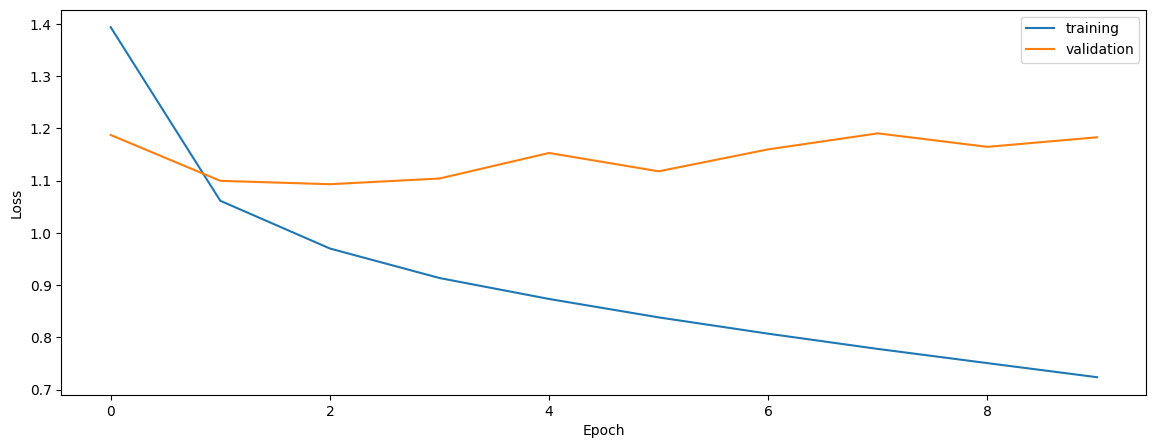

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6396873201659987
0.5660221732164086
0.6093194391287707


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6071579587801353
0.6018179862306369
0.5827079970332882


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6050489651430195
0.5951149741445704
0.5784536668561683


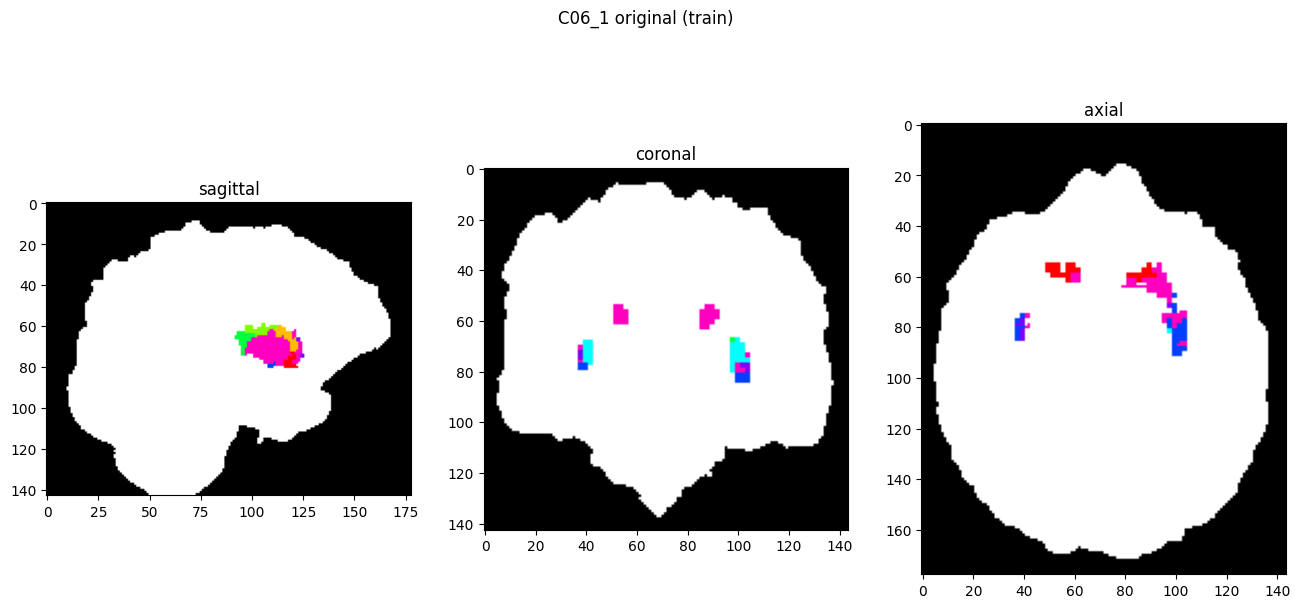

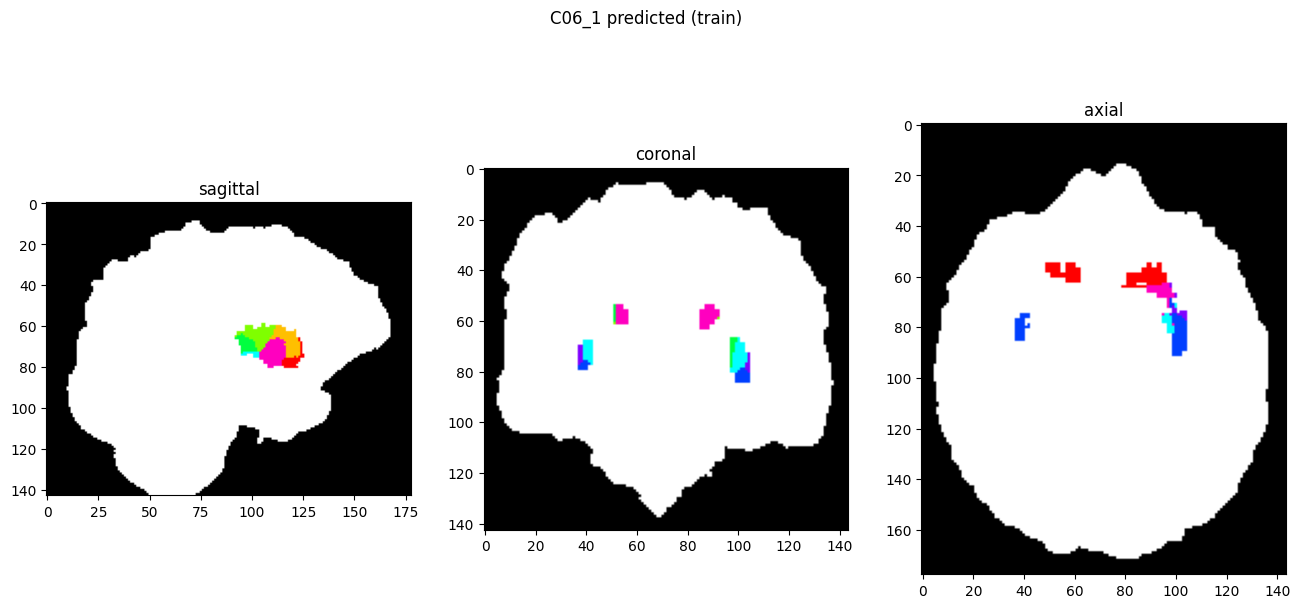

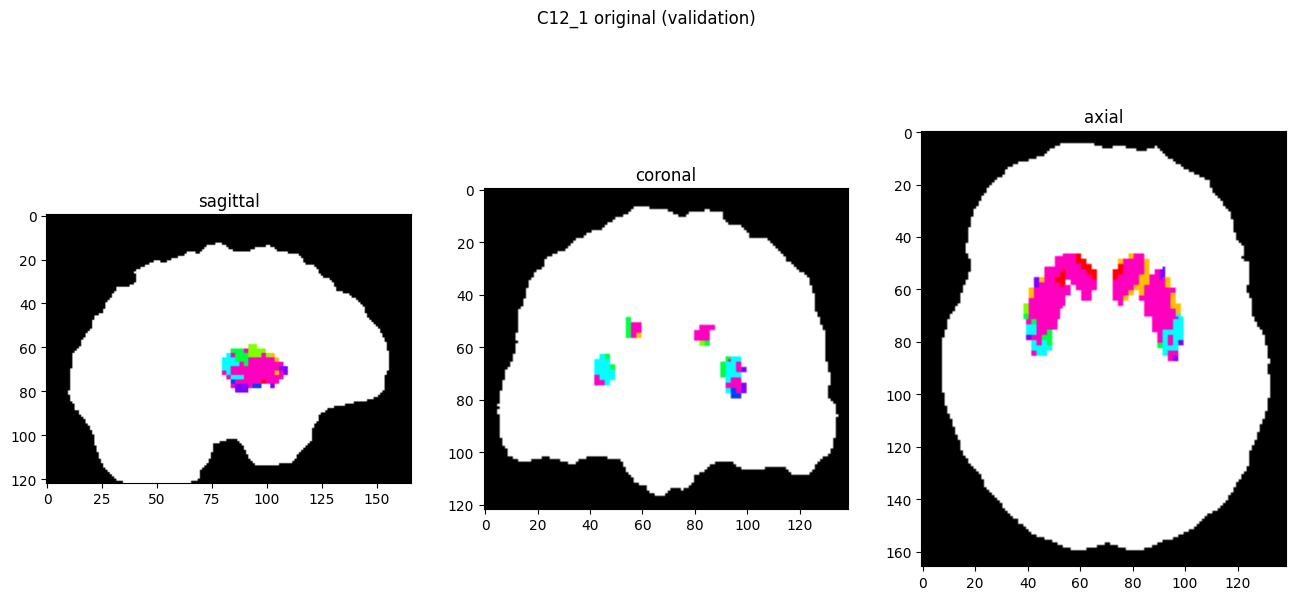

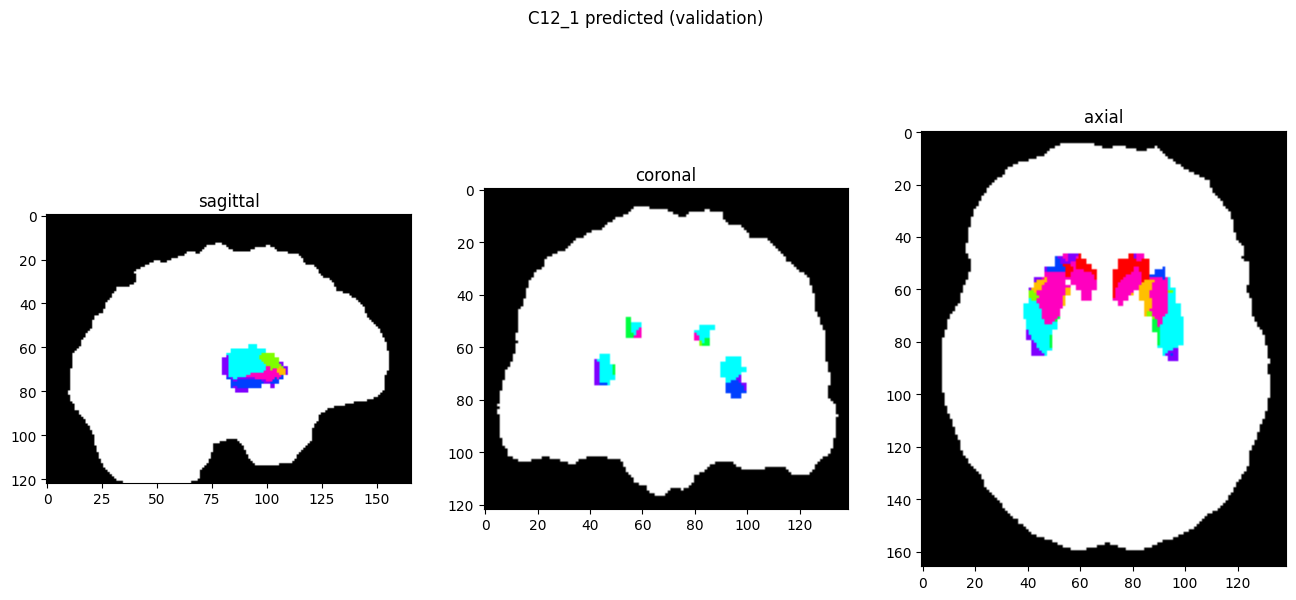

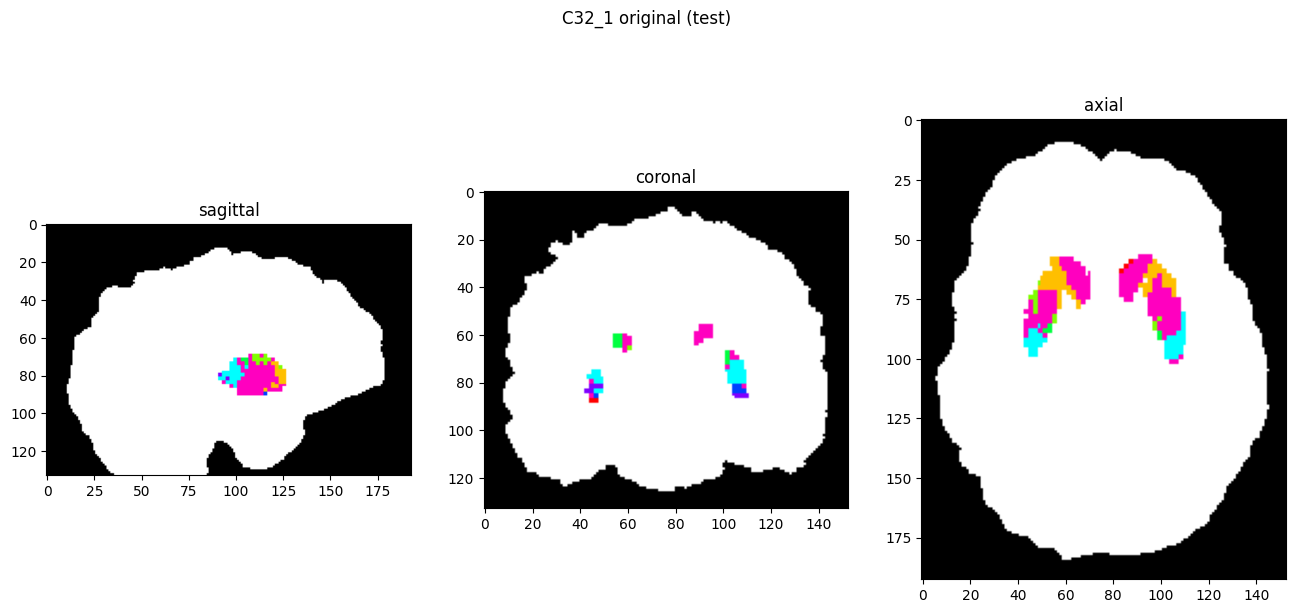

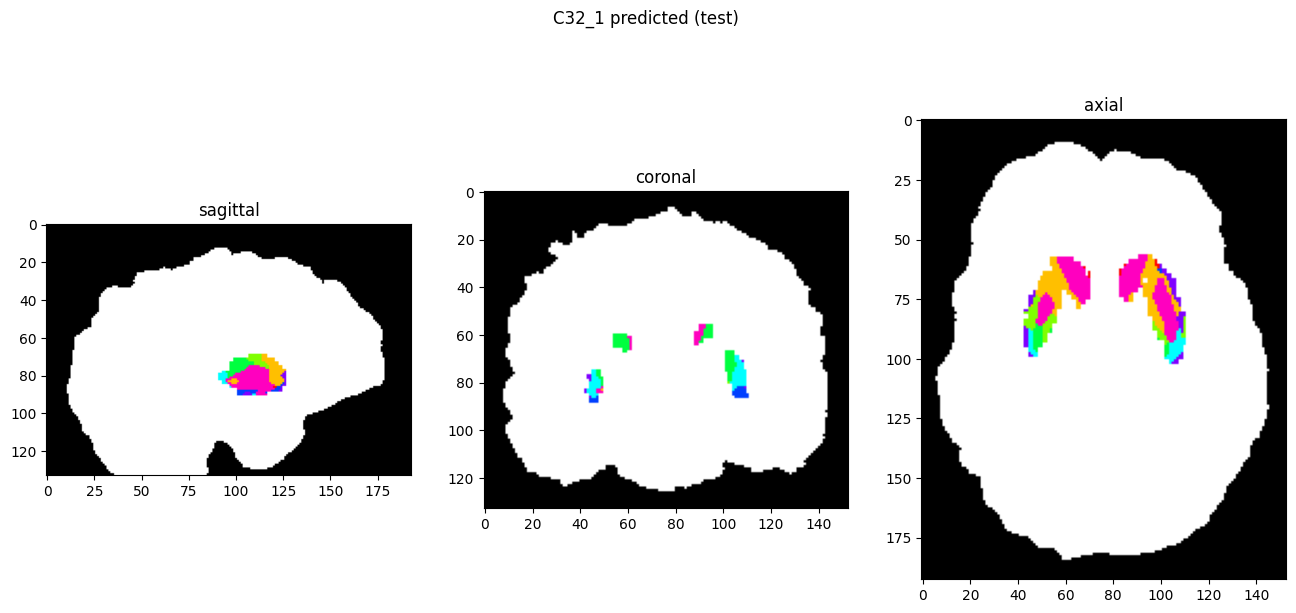

In [10]:
showResults(model, gen, threshold=0)